<a href="https://colab.research.google.com/github/junfeiai/Convex_OPF/blob/main/Test_118.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import sys
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from numpy.random import randn
from scipy.io import loadmat
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model,Sequential,Model
import math
import time
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Lambda,Concatenate,Dropout
import pdb;
import scipy
from keras.constraints import Constraint
from scipy.stats import truncnorm
from scipy.stats import weibull_min
#%cd icnn_data
from sklearn.neighbors import KNeighborsRegressor

In [2]:
#latent_size=64
#icnn_model = load_model('/content/drive/MyDrive/Phd/opf_icnn/grid14_icnn_model_1025.h5')
#model_g = load_model('/content/drive/MyDrive/Phd/icnn_gan/model_118_1211.h5')
model_g = load_model('/content/drive/MyDrive/Phd/icnn_gan/118_icnn_final.h5')
#raise_system = def_encoder_picnn(encoder,icnn_model,grid_size,latent_size)
#encoder_decoder = def_encoder_decoder(encoder,decoder)
#c_icnn_model = load_model('/content/drive/MyDrive/Phd/opf_icnn/grid14_cicnn_model_1003.h5')

In [3]:
def disassemble_mp_structure(solution,grid_size,gen_size):
  vm = solution[:,0:grid_size]
  va = solution[:,grid_size:grid_size*2]

  matpower_p = solution[:,grid_size*2:grid_size*2+gen_size]
  matpower_q = solution[:,grid_size*2+gen_size:]
  p = np.zeros(vm.shape)
  q = np.zeros(va.shape)
  gen_ids = mat_gen[:,0]-1
  j=0
  gen_pos = np.zeros(14)
  for i in range(0,14):
    if i in gen_ids:
      p[:,i]=matpower_p[:,j]
      q[:,i]=matpower_q[:,j]
      j=j+1
      gen_pos[i]=1
  p=p/baseMVA
  q=q/baseMVA
  gen_pos_tf = tf.convert_to_tensor(gen_pos,dtype='float32')
  return p,q,vm,va,gen_pos_tf

def barrier_function(t,u):
  value = tf.multiply(tf.math.reciprocal(t)*(-1.0),tf.math.log(-1.0*u))
  return value

def gen_barrier_function(t,us,gen_pos):
  us = us+gen_pos-1
  #pdb.set_trace()
  value = tf.multiply(tf.math.reciprocal(t)*(-1.0),tf.math.log(-1.0*us))
  return value

def knn_reression(neigh,X_test):
  return neigh.predict(X_test)

def disassemble_gan_structure(condition,solution,grid_size,gen_size):
  demand_p = condition[:,0:grid_size]/baseMVA
  demand_q = condition[:,grid_size:grid_size*2]/baseMVA
  vm = solution[:,0:grid_size]
  va = solution[:,grid_size:grid_size*2]

  matpower_p = solution[:,grid_size*2:grid_size*2+gen_size]
  matpower_q = solution[:,grid_size*2+gen_size:]
  p = np.zeros(vm.shape)
  q = np.zeros(va.shape)
  gen_ids = mat_gen[:,0]-1
  j=0
  gen_pos = np.zeros(grid_size)
  for i in range(0,grid_size):
    if i in gen_ids:
      p[:,i]=matpower_p[:,j]
      q[:,i]=matpower_q[:,j]
      j=j+1
      gen_pos[i]=1
  p=p/baseMVA
  q=q/baseMVA
  #gen_pos_tf = tf.convert_to_tensor(gen_pos,dtype='float32')
  gen_pos = gen_pos
  return demand_p,demand_q,vm,va,p,q,gen_pos

def normalize(x, min, max):
  x_hat = (x-min)/(max-min)
  return x_hat

def denormalize(x_hat,min,max):
  x=x_hat*(max-min)+min
  return x

def feasibility_validation(demand_p,demand_q,n_vm,n_phi,gen_p,gen_q):
  vm = denormalize(n_vm,0.95,1.06)
  local_phi = denormalize(n_phi,np.min(phi),np.max(phi))
  #pdb.set_trace()
  PQ_out = tf.cast(tf.concat([demand_p,demand_q],axis=1),tf.float32)-tf.concat([gen_p,gen_q],axis=1)

  #get voltage on each bus
  v_r = tf.math.multiply(vm,tf.cos(tf.math.multiply(local_phi,\
                                                              tf.constant(math.pi/180,dtype='float64'))))
  v_i = tf.math.multiply(vm,tf.sin(tf.math.multiply(local_phi,\
                                                              tf.constant(math.pi/180,dtype='float64'))))
  V = tf.cast(tf.reshape(tf.complex(v_r,v_i),[-1,grid_size]),tf.complex64)
  #if i==1:
  #  pdb.set_trace()
  #calculate current
  Y_bus_tf = tf.convert_to_tensor(Y_bus)
  I = tf.matmul(V,Y_bus_tf)

  #calculate power injection on each bus
  S_in = tf.math.multiply(V,tf.math.conj(I))
  P_in = tf.math.real(S_in)
  Q_in = tf.math.imag(S_in)
  #pdb.set_trace()
  #evaluate the balance
  PQ_balance = tf.concat([P_in,Q_in],axis=1)+PQ_out
  #mean_PQ_balance = tf.reshape(K.mean(K.abs(PQ_balance),axis=1),[-1,1])
  return PQ_balance

def get_pq_bound(mat_gen):
  '''This is the function to get and format the upper and
    lower bound of active&reactive power at each buse'''
  p_upper = np.zeros(grid_size)
  q_upper = np.zeros(grid_size)
  q_lower = np.zeros(grid_size)
  j=0
  for i in range(0,grid_size):
    if i in (mat_gen[:,0]-1):
      #pdb.set_trace()
      p_upper[i]=mat_gen[j,8]
      q_upper[i]=mat_gen[j,3]
      q_lower[i]=mat_gen[j,4]
      j=j+1
  tf_p_upper = tf.convert_to_tensor(p_upper/baseMVA,dtype='float32')
  tf_q_upper = tf.convert_to_tensor(q_upper/baseMVA,dtype='float32')
  tf_q_lower = tf.convert_to_tensor(q_lower/baseMVA,dtype='float32')
  return tf_p_upper,tf_q_upper,tf_q_lower

def optimality_validation(ix):
  optimal_test_solution = test_solution[ix,:]
  opt_p = optimal_test_solution[-gen_size*2:-gen_size]
  cost1 = opt_p*c1
  cost2 = opt_p*opt_p*c2
  return np.sum(cost1+cost2)

def sample_batch_optimization():
  return

def replaceinf(t):
  return tf.where(tf.math.is_inf(t), tf.zeros_like(t), t)

def replacenan(t):
  return tf.where(tf.math.is_nan(t), tf.zeros_like(t), t)

def app_sin(theta):
  result = (4*theta*(180-theta))/(40500-theta*(180-theta))
  return result

def app_cos(theta):
  result = (32400-4*(theta*theta))/(32400+(theta*theta))
  return result

In [4]:
'''
#This is the block to load data from matlab, and cvs dataset
#Then process them ready for the neural network training
'''
'''
#This is the block to load data from matlab, and cvs dataset
#Then process them ready for the neural network training
'''
#Load grid data from matlab
mat_y = loadmat('/content/drive/MyDrive/Phd/opf_gan/Y_bus118.mat')
mat_gen = loadmat('/content/drive/MyDrive/Phd/opf_gan/IEEE118_gen.mat')['gen118']
mat_load = loadmat('/content/drive/MyDrive/Phd/opf_gan/IEEE118_load.mat')
#mat_gencost = pd.read_csv('new_cost.csv').values[:,1:]
mat_gencost = loadmat('/content/drive/MyDrive/Phd/opf_gan/case118_gencost.mat')['gencost']
line_constraints = loadmat('/content/drive/MyDrive/Phd/opf_gan/grid118_line_constraints.mat')['line_constraint']

#Load dataset
conditions = loadmat('/content/drive/MyDrive/Phd/icnn_gan/118_condition_0325.mat')['conditions_list']
solutions = loadmat('/content/drive/MyDrive/Phd/icnn_gan/118_solution_0325.mat')['datapoints_list']
#conditions = loadmat('/content/drive/MyDrive/Phd/opf_icnn/grid_118_demand.mat')['conditions_list']
#solutions = loadmat('/content/drive/MyDrive/Phd/opf_icnn/grid_118_solution.mat')['datapoints_list']


Y_bus = mat_y['Y_bus118'].toarray().astype('complex64')

grid_size = 118
gen_size = 54
baseMVA = 100

#Load dataset
test_condition_array = loadmat('/content/drive/MyDrive/Phd/icnn_gan/118_opf_condition_0325.mat')['opf_conditions']
test_solution = loadmat('/content/drive/MyDrive/Phd/icnn_gan/118_opf_solution_0325.mat')['opf_solutions']

_,_,_,phi,_,_,gen_pos = disassemble_gan_structure(conditions,solutions,grid_size,gen_size)

max_phi = np.max(phi)
min_phi = np.min(phi)



In [5]:
latent_size=64
#baseMVA = 100
c1 = mat_gencost[:,5]
c2 = mat_gencost[:,4]
grid_size = 118
gen_ids = mat_gen[:,0]-1
c1_full=np.zeros(grid_size)
c2_full=np.zeros(grid_size)
j=0
for i in range(0,grid_size):
  if i in gen_ids:
    c1_full[i] = mat_gencost[j,5]
    c2_full[i] = mat_gencost[j,4]
    j=j+1

test_conditions = test_condition_array/baseMVA
test_points = test_solution

test_vm = test_solution[:,0:grid_size]
test_va = test_solution[:,grid_size:grid_size*2]

test_matpower_p = test_points[:,grid_size*2:grid_size*2+gen_size]
test_matpower_q = test_points[:,grid_size*2+gen_size:]

new_p = np.zeros(test_vm.shape)
new_q = np.zeros(test_vm.shape)
j=0
gen_pos = np.zeros(grid_size)
for i in range(0,grid_size):
  if i in gen_ids:
    new_p[:,i]=test_matpower_p[:,j]
    new_q[:,i]=test_matpower_q[:,j]
    j=j+1
    gen_pos[i]=1
new_p=new_p/baseMVA
new_q=new_q/baseMVA

tf_p_upper,tf_q_upper,tf_q_lower=get_pq_bound(mat_gen)

In [6]:
default_demand_p = mat_load['aa'][:,2]/baseMVA
default_demand_q = mat_load['aa'][:,3]/baseMVA
max_demand_p = default_demand_p*1.2
min_demand_p = default_demand_p*0.8
max_demand_q = default_demand_q*1.2
min_demand_q = default_demand_q*0.8


In [7]:
neigh = KNeighborsRegressor(n_neighbors=226986)
neigh.fit(conditions/100, solutions)
neigh_generation = knn_reression(neigh,conditions[0,:].reshape([1,-1]))
ave_solutions = np.mean(solutions,axis=0).reshape([1,-1])

In [8]:
neigh_generation-ave_solutions

array([[ 1.55431223e-15,  2.50910404e-14, -1.48769885e-14,
        -6.66133815e-15, -1.33226763e-14, -1.77635684e-15,
        -9.76996262e-15,  8.88178420e-16, -5.99520433e-15,
        -1.50990331e-14, -6.21724894e-15,  9.32587341e-15,
        -4.44089210e-16,  1.02140518e-14, -1.06581410e-14,
        -1.99840144e-15,  1.86517468e-14, -3.99680289e-15,
         2.10942375e-14,  1.17683641e-14,  3.55271368e-15,
        -2.39808173e-14,  9.10382880e-15, -1.08801856e-14,
         1.99840144e-15, -1.66533454e-14, -5.32907052e-15,
        -2.88657986e-15, -1.08801856e-14, -2.22044605e-15,
        -1.99840144e-15, -8.21565038e-15, -3.55271368e-15,
         8.21565038e-15,  7.32747196e-15, -7.10542736e-15,
        -8.65973959e-15, -7.54951657e-15, -6.21724894e-15,
         5.32907052e-15, -3.46389584e-14, -2.04281037e-14,
        -1.33226763e-15, -7.10542736e-15, -1.04360964e-14,
         9.32587341e-15,  1.77635684e-15,  1.55431223e-15,
        -2.57571742e-14,  4.21884749e-15,  1.55431223e-1

In [9]:
def convex_optimization(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf,model_g,epsilon):
  df_dp = None
  df_dq = None
  df_vm = None
  df_va = None
  beta = 0.6
  obj = []
  for j in range(0,1000):
    with tf.GradientTape(persistent=True) as tape:
      #pdb.set_trace()

      x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
      tape.watch(x_hat)
      financial_cost1=tf.cast(tf.math.multiply(gen_p_full_tf*100, c1_full),tf.float32)
      financial_cost2=tf.math.multiply(K.square(tf.cast(gen_p_full_tf*100,tf.float32)), c2_full)
      financial_cost = financial_cost1+financial_cost2
      print(tf.reduce_sum(financial_cost1+financial_cost2,axis=1))

      #f_score = feasibility_validation(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf)
      f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
      #pdb.set_trace()

      #pred_err.append(f_score.numpy())

      f_score_constraint = f_score-epsilon
      vm_tf = denormalize(n_vm_tf,0.95,1.06)
      va_tf = denormalize(n_va_tf,min_phi,max_phi)
      #t=0.1
      objective = tf.reduce_sum(financial_cost)+1/t*tf.math.log(-f_score_constraint)
      obj.append(objective.numpy())
      df_dx = tape.gradient(objective,x_hat)
      if df_dp is None:
        df_dp = df_dx[4]
      else:
        df_dp = df_dp*(1-beta)+df_dx[4]
      #tape.gradient(objective,gen_p_full_tf)
      if df_dq is None:
        df_dq = df_dx[5]
      else:
        df_dq = df_dq*(1-beta)+df_dx[5]
      if df_vm is None:
        df_vm = df_dx[2]
      else:
        df_vm = df_vm*(1-beta)+df_dx[2]
      if df_va is None:
        df_va = df_dx[3]
      else:
        df_va = df_va*(1-beta)+df_dx[3]
      #tape.gradient(objective,n_vm_tf)
      #df_va = df_dx[3]
      #tape.gradient(objective,n_va_tf)
      #pdb.set_trace()
      gen_p_full_tf = gen_p_full_tf-0.0000005*df_dp
      f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
      f_score_constraint = f_score-epsilon
      #alpha_1 = tf.reduce_mean((replaceinf(1/(t*(gen_p_full_tf)))-replaceinf(1/(t*(tf_p_upper-gen_p_full_tf)))-replacenan((2*c2_full*10000-c1_full*100)/replacenan(df_dp))))
      '''objective_1 = tf.reduce_sum(financial_cost)+\
                    replaceinf(1/t*tf.math.log(-f_score_constraint))'''
                    #+replaceinf(1/t*tf.math.log(tf_q_upper-gen_q_full_tf))+replaceinf(1/t*tf.math.log(gen_q_full_tf-tf_q_lower))\
                    #+tf.cast(1/t*tf.math.log(1.06-vm_tf)+1/t*tf.math.log(vm_tf-0.95),dtype=tf.float32)
      gen_q_full_tf = gen_q_full_tf-0.0000001*df_dq
      n_vm_tf = n_vm_tf-0.000001*df_vm
      vm_tf = denormalize(n_vm_tf,0.95,1.06)
      n_va_tf = n_va_tf-0.000001*df_va
      f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
      if f_score<epsilon:
        best_cost = tf.reduce_sum(financial_cost1+financial_cost2,axis=1).numpy()[0]
        cost_list.append(best_cost)
      else:
        break
  return n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf,obj

def find_warm_start_point1(warmer,condition):
  gen_p,gen_q,n_vm,n_va = ebm.warmer([condition[0:grid_size].reshape([1,-1]),condition[grid_size:grid_size*2].reshape([1,-1])])

  #gen_p_full = np.zeros(n_vm.shape)
  #gen_q_full = np.zeros(n_vm.shape)
  #kk=0
  #for m in range(0,grid_size):

   # if m in gen_ids:
   #   gen_p_full[:,m]=gen_p[:,kk]
   #   gen_q_full[:,m]=gen_q[:,kk]
   # kk=kk+1
  #pdb.set_trace()
  #n_vm = n_vm_universal
  #n_va = n_va_universal
  #gen_p_full = gen_p_universal
  #gen_q_full = gen_q_universal

  #n_vm = tf.convert_to_tensor(n_vm0)
  #n_va = tf.convert_to_tensor(n_va0)
  #gen_p_full = tf.convert_to_tensor(gen_p0)
  #gen_q_full = tf.convert_to_tensor(gen_q0)
  #best_list = []
  #pdb.set_trace()

  #n_demand_p = replaceinf(replacenan(normalize(p_condition,max_demand_p,min_demand_p)))
  #n_demand_q = replacenan(normalize(q_condition,max_demand_q,min_demand_p))
  n_vm_tf = tf.convert_to_tensor(n_vm)
  n_va_tf = tf.convert_to_tensor(n_va)
  gen_p_full_tf =tf.cast(tf.convert_to_tensor(gen_p),tf.float32)
  gen_q_full_tf = tf.cast(tf.convert_to_tensor(gen_q),tf.float32)
  #x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
  #alpha = np.zeros([1,1])
  best_cost = 0
  #pdb.set_trace()
  f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
  if f_score>epsilon:
    for k in range(0,100):
      '''Find good warm start point'''
      with tf.GradientTape(persistent=True) as tape:
        x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
        tape.watch(x_hat)
        f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        print('trying to find start point,score=:'+str(f_score))
        if f_score<=epsilon:
          break
        df_dp = tape.gradient(f_score,gen_p_full_tf)
        df_dq = tape.gradient(f_score,gen_q_full_tf)
        df_vm = tape.gradient(f_score,n_vm_tf)
        df_va = tape.gradient(f_score,n_va_tf)
        gen_p_full_tf = gen_p_full_tf-0.00001*replacenan(df_dp)
        gen_q_full_tf = gen_q_full_tf-0.00001*replacenan(df_dq)
        gen_p_full_tf = tf.minimum(tf.maximum(gen_p_full_tf,0),tf_p_upper)
        gen_q_full_tf = tf.minimum(tf.maximum(gen_q_full_tf,tf_q_lower),tf_q_upper)
        n_vm_tf = n_vm_tf-0.0000001*replacenan(df_vm)
        vm_tf = denormalize(n_vm_tf,0.95,1.06)
        n_va_tf = n_va_tf-0.00001*replacenan(df_va)
        #f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        #print(gen_p_full_tf)
  return gen_p_full_tf,gen_q_full_tf,n_vm_tf,n_va_tf

In [10]:
class EBM():
  def __init__(self):
    self.grid_size = 118
    #self.latent_size = 64
    self.gen_size = 54
    self.baseMVA = 100
    self.vali_size = 10000
    #self.g_model = self.define_generator()

  def reverse_relu(self,x):
    out = K.minimum(x,0)
    return out

  def adding_random_noise(self,x,per=0.1):
    shape = x.shape
    noise = np.random.normal(0,per,shape)*x+x
    return noise

  def generate_fake_samples_by_adding_noise(self,seed_x):
    [batch_demand_p,batch_demand_q,batch_n_vm,batch_n_phi,batch_gen_p,batch_gen_q] = seed_x
    #batch_n_vm_hat = self.adding_random_noise(batch_n_vm)
    #batch_n_phi_hat = self.adding_random_noise(batch_n_phi)
    batch_gen_p_hat = self.adding_random_noise(batch_gen_p)
    batch_gen_q_hat = self.adding_random_noise(batch_gen_q)
    x_hat = [batch_demand_p,batch_demand_q,batch_n_vm,batch_n_phi,batch_gen_p_hat,batch_gen_q_hat]
    return x_hat

  def generate_fake_samples_by_swapping_solutions(self,seed_x):
    [batch_demand_p,batch_demand_q,batch_n_vm,batch_n_phi,batch_gen_p,batch_gen_q] = seed_x
    index = seed_x[0].shape[0]
    arr = np.arange(index)
    np.random.shuffle(arr)
    batch_n_vm_hat = batch_n_vm[arr,:]
    batch_n_phi_hat = batch_n_phi[arr,:]
    batch_gen_p_hat = batch_gen_p[arr,:]
    batch_gen_q_hat = batch_gen_q[arr,:]
    x_hat = [batch_demand_p,batch_demand_q,batch_n_vm_hat,batch_n_phi_hat,batch_gen_p_hat,batch_gen_q_hat]
    return x_hat

  def generate_fake_samples_by_uniform_sampling(self,seed_x):
    [batch_demand_p,batch_demand_q,_,_,_,_] = seed_x
    batch_size = batch_demand_p.shape[0]
    grid_size = batch_demand_p.shape[1]
    q_sample = np.random.uniform(0,0.3,(batch_size,grid_size))*(ebm.q_upper-ebm.q_lower).numpy().reshape([1,grid_size])\
                                                    +ebm.q_lower.numpy().reshape([1,grid_size])
    p_sample = np.random.uniform(0,0.3,(batch_size,grid_size))*ebm.p_upper.numpy().reshape([1,grid_size])
    n_vm_sample = np.random.uniform(0,1,(batch_size,grid_size))
    n_phi_sample = np.random.uniform(0,1,(batch_size,grid_size))
    x_hat = [batch_demand_p,batch_demand_q,n_vm_sample,n_phi_sample,p_sample,q_sample]
    return x_hat

  def generate_real_samples(self,n_samples):
    # choose random instances
    ix = np.random.randint(0, self.demand_p.shape[0], n_samples)
    # select images and labels
    batch_demand_p,batch_demand_q,batch_n_vm,batch_n_phi,batch_gen_p,batch_gen_q = self.demand_p[ix],\
                                self.demand_q[ix],self.n_vm[ix],self.n_phi[ix],self.gen_p[ix],self.gen_q[ix]
    x = [batch_demand_p,batch_demand_q,batch_n_vm,batch_n_phi,batch_gen_p,batch_gen_q]
    return x

  def define_warmer(self):
    l1 = 512
    l2 = 256
    l3 = 128
    l4 = 64
    l5 = 32
    demand_p = keras.Input(shape=(self.grid_size))
    demand_q = keras.Input(shape=(self.grid_size))
    x = keras.layers.concatenate([demand_p,demand_q],axis=1)
    x = layers.Dense(l1, activation='tanh')(x)
    x = layers.Dense(l2, activation='tanh')(x)
    x = layers.Dense(l3, activation='tanh')(x)
    #x = layers.Dense(l4, activation='relu')(x)
    hidden = layers.Dense(l5, activation='tanh')(x)
    g_active = layers.Dense(self.grid_size,dtype='float32',activation='sigmoid')(hidden)
    g_active = tf.math.multiply(g_active,ebm.p_upper)
    g_reactive = layers.Dense(self.grid_size,dtype='float32',activation='sigmoid')(hidden)
    g_reactive = tf.math.multiply(g_reactive,ebm.p_upper-ebm.q_lower)\
                                                      +ebm.q_lower
    bus_vm = layers.Dense(self.grid_size,dtype='float32',activation='sigmoid')(hidden)
    bus_va = layers.Dense(self.grid_size,dtype='float32',activation='sigmoid')(hidden)
    g_model = keras.Model(inputs=[demand_p,demand_q], outputs=[g_active,g_reactive,bus_vm,bus_va])
    #d_model = keras.Model(inputs=[demand_p,demand_q,n_vm,n_phi,gen_p,gen_q], outputs=d_out)
    return g_model

  def define_ensemble(self,warmer,icnn):
    [g_active,g_reactive,bus_vm,bus_va] = warmer.output
    [demand_p,demand_q] = warmer.input
    gan_output = icnn([demand_p,demand_q,bus_vm,bus_va,g_active,g_reactive])
    # define gan model as taking noise and label and outputting a classification
    model = keras.Model([demand_p,demand_q], gan_output)
    return model


  def define_model(self):
    l1 = 128
    l2 = 256
    l3 = 512
    l4 = 1024
    #l5 = 4
    demand_p = keras.Input(shape=(self.grid_size))
    demand_q = keras.Input(shape=(self.grid_size))
    n_vm = keras.Input(shape=(self.grid_size))
    n_phi = keras.Input(shape=(self.grid_size))
    gen_p = keras.Input(shape=(self.grid_size))
    gen_q = keras.Input(shape=(self.grid_size))
    x = keras.layers.concatenate([demand_p,demand_q,n_vm,n_phi,gen_p,gen_q],axis=1)
    z1 = layers.Dense(l1, activation=None)(x)
    a2 = layers.Add()([layers.Dense(l1, activation=None,kernel_constraint='NonNeg')(z1),layers.Dense(l1, activation=None)(x)])
    z2 = layers.ReLU()(a2)
    a3 = layers.Add()([layers.Dense(l2, activation=None,kernel_constraint='NonNeg')(z2),layers.Dense(l2, activation=None)(x)])
    z3 = layers.ReLU()(a3)
    a4 = layers.Add()([layers.Dense(l3, activation=None,kernel_constraint='NonNeg')(z3),layers.Dense(l3, activation=None)(x)])
    z4 = layers.ReLU()(a4)
    a5 = layers.Add()([layers.Dense(l4, activation=None,kernel_constraint='NonNeg')(z4),layers.Dense(l4, activation=None)(x)])
    z5 = layers.ReLU()(a5)
    #a6 = layers.Add()([layers.Dense(l5, activation=None,kernel_constraint='NonNeg')(z5),layers.Dense(l5, activation=None)(x)])
    #z6 = layers.ReLU()(a6)
    #d_out = layers.Dense(1,dtype='float32',activation=None,kernel_constraint='NonNeg')(z5)
    f_score = layers.Dense(1,dtype='float32',activation=None,kernel_constraint='NonNeg')(z5)
    model = keras.Model(inputs=[demand_p,demand_q,n_vm,n_phi,gen_p,gen_q], outputs=f_score)
    #d_model = keras.Model(inputs=[demand_p,demand_q,n_vm,n_phi,gen_p,gen_q], outputs=d_out)
    return model


  def get_minmax_voltage(self,phi):
    self.max_vm = 1.06
    self.min_vm = 0.95
    #No need to bound angles, only used for normalization
    self.max_phi = np.max(phi)
    self.min_phi = np.min(phi)
    return

  def normalize(self,x, min, max):
    x_hat = (x-min)/(max-min)
    return x_hat

  def denormalize(self,x_hat,min,max):
    x=x_hat*(max-min)+min
    return x

  def get_demand_bound(self,mat_load):
    default_demand_p = mat_load['aa'][:,2]/self.baseMVA
    default_demand_q = mat_load['aa'][:,3]/self.baseMVA
    self.max_demand_p = default_demand_p*1.2
    self.min_demand_p = default_demand_p*0.8
    self.max_demand_q = default_demand_q*1.2
    self.min_demand_q = default_demand_q*0.8
    return

  def data_prepare(self,condition,solution,mat_gen,mat_load):
    #Step1: get every single variable from the matlab data structure
    demand_p,demand_q,vm,phi,p,q = self.disassemble_mp_structure(condition,solution)
    #Step2: Get min max value for each variable
    self.get_minmax_voltage(phi)
    self.get_pq_bound(mat_gen)
    self.get_demand_bound(mat_load)
    #Step3: Normalization if needed
    n_vm = self.normalize(vm,self.min_vm,self.max_vm)
    n_phi = self.normalize(phi,self.min_phi,self.max_phi)
    #pdb.set_trace()
    self.demand_p = demand_p[0:-self.vali_size,:]
    self.demand_q = demand_q[0:-self.vali_size,:]
    self.n_vm = n_vm[0:-self.vali_size,:]
    self.n_phi = n_phi[0:-self.vali_size,:]
    self.gen_p = p[0:-self.vali_size,:]
    self.gen_q = q[0:-self.vali_size,:]

    self.vali_demand_p = demand_p[-self.vali_size:,:]
    self.vali_demand_q = demand_q[-self.vali_size:,:]
    self.vali_n_vm = n_vm[-self.vali_size:,:]
    self.vali_n_phi = n_phi[-self.vali_size:,:]
    self.vali_gen_p = p[-self.vali_size:,:]
    self.vali_gen_q = q[-self.vali_size:,:]
    return

  def disassemble_mp_structure(self,condition,solution):
    demand_p = condition[:,0:self.grid_size]/self.baseMVA
    demand_q = condition[:,self.grid_size:self.grid_size*2]/self.baseMVA
    vm = solution[:,0:self.grid_size]
    va = solution[:,self.grid_size:self.grid_size*2]

    matpower_p = solution[:,self.grid_size*2:self.grid_size*2+self.gen_size]
    matpower_q = solution[:,self.grid_size*2+self.gen_size:]
    p = np.zeros(vm.shape)
    q = np.zeros(va.shape)
    gen_ids = mat_gen[:,0]-1
    j=0
    gen_pos = np.zeros(self.grid_size)
    for i in range(0,self.grid_size):
      if i in gen_ids:
        p[:,i]=matpower_p[:,j]
        q[:,i]=matpower_q[:,j]
        j=j+1
        gen_pos[i]=1
    p=p/self.baseMVA
    q=q/self.baseMVA
    #gen_pos_tf = tf.convert_to_tensor(gen_pos,dtype='float32')
    self.gen_pos = gen_pos
    return demand_p,demand_q,vm,va,p,q

  def get_pq_bound(self,mat_gen):
    '''This is the function to get and format the upper and
      lower bound of active&reactive power at each buse'''
    p_upper = np.zeros(self.grid_size)
    q_upper = np.zeros(self.grid_size)
    q_lower = np.zeros(self.grid_size)
    j=0
    for i in range(0,self.grid_size):
      if i in (mat_gen[:,0]-1):
        #pdb.set_trace()
        p_upper[i]=mat_gen[j,8]
        q_upper[i]=mat_gen[j,3]
        q_lower[i]=mat_gen[j,4]
        j=j+1
    tf_p_upper = tf.convert_to_tensor(p_upper/self.baseMVA,dtype='float32')
    tf_q_upper = tf.convert_to_tensor(q_upper/self.baseMVA,dtype='float32')
    tf_q_lower = tf.convert_to_tensor(q_lower/self.baseMVA,dtype='float32')
    self.p_upper = tf_p_upper
    self.q_upper = tf_q_upper
    self.q_lower = tf_q_lower
    return

In [11]:
hop2_points = np.array([20,21,43,51,87,94,107])
def calibration_by_partial_partial_new(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf,K=1):
  pq_demand = np.hstack([p_condition.numpy(),q_condition.numpy()])
  #get voltage on each bus
  vm = denormalize(n_vm_tf.numpy(),0.95,1.06)
  local_phi = denormalize(n_va_tf.numpy(),np.min(phi),np.max(phi))
  v_r = vm*np.cos(local_phi*math.pi/180)
  v_i = vm*np.sin(local_phi*math.pi/180)
  V = v_r+1j*v_i
  P_g = gen_p_full_tf.numpy()
  Q_g = gen_q_full_tf.numpy()
  Y_bus_np = Y_bus_tf.numpy()
  best_cost = 1e6
  pq_list = []
  PQ_balance_1 = 100
  P_g_0 = np.copy(P_g)

  for k in range(0,K):
    vm = np.abs(V)
    va = np.angle(V)*180/math.pi
    pq_res = feasibility_validation(p_condition,q_condition,normalize(vm,0.95,1.06),normalize(va,np.min(phi),np.max(phi)),P_g,Q_g)
    if np.max(pq_res)<1e-5:
      break
    flag=0
    print(str(k)+', max res=:'+str(np.max(pq_res)))
    #cost_in_dollar = np.sum(c1_full*P_g*100+c2_full*P_g*P_g*10000)
    #print(cost_in_dollar)
    P_tran = P_g-p_condition.numpy()
    Q_tran = Q_g-q_condition.numpy()
    S_tran_conj = P_tran-1j* Q_tran

    for i in hop2_points:
      i = int(i)
      #if i not in gen_ids:
        #print(i)
      old_vi = np.copy(V[0,i])
      for iter in range(0,100):
        S_tran_conj_i = S_tran_conj[0,i]
        S_tc_vc_i = S_tran_conj_i/np.conjugate(V[0,i])
        I_test = 0
        for j in range(0,grid_size):
          if i!=j:
            I_test = I_test+V[0,j]*Y_bus_np[i,j]

        res = S_tc_vc_i-I_test
        V_tmp = res/Y_bus_np[i,i]
        vm_i = abs(V_tmp)
        phase_i = np.angle(V_tmp)
        V[0,i] = V_tmp
        res_prev = old_vi-V[0,i]
        abs_res_prev = abs(res_prev)
        old_vi = V[0,i]
        #print('ite'+str(iter)+',bus:'+str(i)+',res='+str(abs_res_prev))
        if abs_res_prev<1e-6:
          '''if i ==0:
            phase_i = 0
          if vm_i>1.06:
            vm_i=1.06
          if vm_i<0.95:
            vm_i = 0.95'''
          v_r_i = vm_i*np.cos(phase_i)
          v_i_i = vm_i*np.sin(phase_i)
          V_tmp = v_r_i+1j*v_i_i
          break
        else:
          flag = 1
    if flag==0 and k>0:
      break
    for i in range(0,grid_size):
      if i not in hop2_points:
        if i not in gen_ids:
          i = int(i)
          #if i not in gen_ids:
            #print(i)
          old_vi = np.copy(V[0,i])
          for iter in range(0,100):
            S_tran_conj_i = S_tran_conj[0,i]
            S_tc_vc_i = S_tran_conj_i/np.conjugate(V[0,i])
            I_test = 0
            for j in range(0,grid_size):
              if i!=j:
                I_test = I_test+V[0,j]*Y_bus_np[i,j]

            res = S_tc_vc_i-I_test
            V_tmp = res/Y_bus_np[i,i]
            vm_i = abs(V_tmp)
            phase_i = np.angle(V_tmp)
            V[0,i] = V_tmp
            res_prev = old_vi-V[0,i]
            abs_res_prev = abs(res_prev)
            old_vi = V[0,i]
            #print('ite'+str(iter)+',bus:'+str(i)+',res='+str(abs_res_prev))
            if abs_res_prev<1e-20:
              flag=1
              if i ==0:
                phase_i = 0
              if vm_i>1.06:
                vm_i=1.06
              if vm_i<0.95:
                vm_i = 0.95
              v_r_i = vm_i*np.cos(phase_i)
              v_i_i = vm_i*np.sin(phase_i)
              V_tmp = v_r_i+1j*v_i_i
              break
    for i in gen_ids:
      i = int(i)
      P_g[0,i] = np.real(np.conjugate(V[0,i])*(np.matmul(V,Y_bus_np)[0,i]))+p_condition[0,i]
      Q_g[0,i] = (-1)*np.imag(np.conjugate(V[0,i])*(np.matmul(V,Y_bus_np)[0,i]))+q_condition[0,i]
    if flag==0:
      break
    PQ_out = pq_demand-np.hstack([P_g,Q_g])
    #print(V)
    I = np.matmul(V,Y_bus_np)
    #calculate power injection on each bus
    S_in = V*np.conjugate(I)
    P_in = np.real(S_in)
    Q_in = np.imag(S_in)
    #pdb.set_trace()
    #evaluate the balance
    PQ_balance = np.hstack([P_in,Q_in])+PQ_out
    #print(PQ_balance)
    pq_list.append(np.mean(abs(PQ_balance)))
  #print(pq_list)
  #print(np.mean(abs(P_g_0-P_g)))
  #plt.plot(pq_list)

  return V,P_g,Q_g,None


def calibration_by_partial_partial(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf):
  pq_demand = np.hstack([p_condition.numpy(),q_condition.numpy()])
  #get voltage on each bus
  vm = denormalize(n_vm_tf.numpy(),0.95,1.06)
  local_phi = denormalize(n_va_tf.numpy(),np.min(phi),np.max(phi))
  v_r = vm*np.cos(local_phi*math.pi/180)
  v_i = vm*np.sin(local_phi*math.pi/180)
  V = v_r+1j*v_i
  P_g = gen_p_full_tf.numpy()
  Q_g = gen_q_full_tf.numpy()
  Y_bus_np = Y_bus_tf.numpy()
  best_cost = 1e6
  pq_list = []
  PQ_balance_1 = 100
  P_g_0 = np.copy(P_g)
  for k in range(0,100):
    #cost_in_dollar = np.sum(c1_full*P_g*100+c2_full*P_g*P_g*10000)
    #print(cost_in_dollar)
    P_tran = P_g-p_condition.numpy()
    Q_tran = Q_g-q_condition.numpy()
    S_tran_conj = P_tran-1j* Q_tran

    for i in hop2_points:
      i = int(i)
      #if i not in gen_ids:
        #print(i)
      S_tran_conj_i = S_tran_conj[0,i]
      S_tc_vc_i = S_tran_conj_i/np.conjugate(V[0,i])
      I_test = 0
      for j in range(0,grid_size):
        if i!=j:
          I_test = I_test+V[0,j]*Y_bus_np[i,j]

      res = S_tc_vc_i-I_test
      V_tmp = res/Y_bus_np[i,i]
      vm_i = abs(V_tmp)
      phase_i = np.angle(V_tmp)
      if i ==0:
        phase_i = 0
      if vm_i>1.06:
        vm_i=1.06
      if vm_i<0.95:
        vm_i = 0.95
      v_r_i = vm_i*np.cos(phase_i)
      v_i_i = vm_i*np.sin(phase_i)
      V_tmp = v_r_i+1j*v_i_i

      V[0,i] = V[0,i]+1.6*(V_tmp-V[0,i])

    for i in range(0,grid_size):
      i = int(i)
      if (i not in gen_ids) and (i not in hop2_points):
        #print(i)
        S_tran_conj_i = S_tran_conj[0,i]
        S_tc_vc_i = S_tran_conj_i/np.conjugate(V[0,i])
        I_test = 0
        for j in range(0,grid_size):
          if i!=j:
            I_test = I_test+V[0,j]*Y_bus_np[i,j]

        res = S_tc_vc_i-I_test
        V_tmp = res/Y_bus_np[i,i]
        vm_i = abs(V_tmp)
        phase_i = np.angle(V_tmp)
        if i ==0:
          phase_i = 0
        if vm_i>1.06:
          vm_i=1.06
        if vm_i<0.95:
          vm_i = 0.95
        v_r_i = vm_i*np.cos(phase_i)
        v_i_i = vm_i*np.sin(phase_i)
        V_tmp = v_r_i+1j*v_i_i

        V[0,i] = V[0,i]+1.6*(V_tmp-V[0,i])
    for i in gen_ids:
      i = int(i)
      P_g[0,i] = np.real(np.conjugate(V[0,i])*(np.matmul(V,Y_bus_np)[0,i]))+p_condition[0,i]
      Q_g[0,i] = (-1)*np.imag(np.conjugate(V[0,i])*(np.matmul(V,Y_bus_np)[0,i]))+q_condition[0,i]
    '''I = np.matmul(V,Y_bus_np)
    S_in = V*np.conjugate(I)
    P_in = np.real(S_in)
    Q_in = np.imag(S_in)
    PQ_out = pq_demand-np.hstack([P_g,Q_g])
    PQ_balance = np.mean(abs(np.hstack([P_in,Q_in])+PQ_out))
    pq_list.append(PQ_balance)'''
    if np.mean(abs(P_g_0-P_g))<3e-5:
      break
    #PQ_balance_1 = PQ_balance
    #print(PQ_balance)
    #print(np.mean(abs(P_g_0-P_g)))
    P_g_0 = np.copy(P_g)

  return n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf,None

def find_warm_start_point(neigh,condition):
  neigh_generation = knn_reression(neigh,condition.reshape([1,-1]))

  vm = neigh_generation[:,0:grid_size]
  #vm = np.ones([1,14])
  n_vm = normalize(vm,0.95,1.06)
  va = neigh_generation[:,grid_size:grid_size*2]
  #va = np.zeros([1,14])
  n_va = normalize(va,min_phi,max_phi)
  #gen_p = np.ones([1,5])
  gen_p=neigh_generation[:,grid_size*2:grid_size*2+gen_size]
  #gen_q = np.ones([1,5])
  gen_q=neigh_generation[:,grid_size*2+gen_size:grid_size*2+gen_size*2]
  gen_p_full = np.zeros(vm.shape)
  gen_q_full = np.zeros(vm.shape)
  k=0
  for m in range(0,grid_size):
    if m in gen_ids:
      gen_p_full[:,m]=gen_p[:,k]/baseMVA
      gen_q_full[:,m]=gen_q[:,k]/baseMVA
      k=k+1

  #n_vm = n_vm_universal
  #n_va = n_va_universal
  #gen_p_full = gen_p_universal
  #gen_q_full = gen_q_universal

  #n_vm = tf.convert_to_tensor(n_vm0)
  #n_va = tf.convert_to_tensor(n_va0)
  #gen_p_full = tf.convert_to_tensor(gen_p0)
  #gen_q_full = tf.convert_to_tensor(gen_q0)
  #best_list = []
  #pdb.set_trace()

  #n_demand_p = replaceinf(replacenan(normalize(p_condition,max_demand_p,min_demand_p)))
  #n_demand_q = replacenan(normalize(q_condition,max_demand_q,min_demand_p))
  n_vm_tf = tf.convert_to_tensor(n_vm)
  n_va_tf = tf.convert_to_tensor(n_va)
  gen_p_full_tf =tf.cast(tf.convert_to_tensor(gen_p_full),tf.float32)
  gen_q_full_tf = tf.cast(tf.convert_to_tensor(gen_q_full),tf.float32)
  #x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
  #alpha = np.zeros([1,1])
  best_cost = 0
  f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
  if f_score>epsilon:
    for k in range(0,100):
      '''Find good warm start point'''
      with tf.GradientTape(persistent=True) as tape:
        x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
        tape.watch(x_hat)
        f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        print('trying to find start point,score=:'+str(f_score))
        if f_score<=epsilon:
          break
        df_dp = tape.gradient(f_score,gen_p_full_tf)
        df_dq = tape.gradient(f_score,gen_q_full_tf)
        df_vm = tape.gradient(f_score,n_vm_tf)
        df_va = tape.gradient(f_score,n_va_tf)
        gen_p_full_tf = gen_p_full_tf-0.00001*replacenan(df_dp)
        gen_q_full_tf = gen_q_full_tf-0.00001*replacenan(df_dq)
        n_vm_tf = n_vm_tf-0.0000001*replacenan(df_vm)
        vm_tf = denormalize(n_vm_tf,0.95,1.06)
        n_va_tf = n_va_tf-0.00001*replacenan(df_va)
        #f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
  return gen_p_full_tf,gen_q_full_tf,n_vm_tf,n_va_tf

def find_warm_start_point1(warmer,condition):
  n_vm_tf = tf.convert_to_tensor(n_vm)
  n_va_tf = tf.convert_to_tensor(n_va)
  gen_p_full_tf =tf.cast(tf.convert_to_tensor(gen_p),tf.float32)
  gen_q_full_tf = tf.cast(tf.convert_to_tensor(gen_q),tf.float32)
  #x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
  #alpha = np.zeros([1,1])
  best_cost = 0
  #pdb.set_trace()
  f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
  if f_score>epsilon:
    for k in range(0,100):
      '''Find good warm start point'''
      with tf.GradientTape(persistent=True) as tape:
        x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
        tape.watch(x_hat)
        f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        print('trying to find start point,score=:'+str(f_score))
        if f_score<=epsilon:
          break
        df_dp = tape.gradient(f_score,gen_p_full_tf)
        df_dq = tape.gradient(f_score,gen_q_full_tf)
        df_vm = tape.gradient(f_score,n_vm_tf)
        df_va = tape.gradient(f_score,n_va_tf)
        gen_p_full_tf = gen_p_full_tf-0.00001*replacenan(df_dp)
        gen_q_full_tf = gen_q_full_tf-0.00001*replacenan(df_dq)
        gen_p_full_tf = tf.minimum(tf.maximum(gen_p_full_tf,0),tf_p_upper)
        gen_q_full_tf = tf.minimum(tf.maximum(gen_q_full_tf,tf_q_lower),tf_q_upper)
        n_vm_tf = n_vm_tf-0.0000001*replacenan(df_vm)
        vm_tf = denormalize(n_vm_tf,0.95,1.06)
        n_va_tf = n_va_tf-0.00001*replacenan(df_va)
        #f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        #print(gen_p_full_tf)
  return gen_p_full_tf,gen_q_full_tf,n_vm_tf,n_va_tf

def find_warm_start_point2(ebm,condition):
  #ave_solutions = median_solutions
  vm = ave_solutions[0,0:ebm.grid_size].reshape([1,-1])
  va = ave_solutions[0,ebm.grid_size:ebm.grid_size*2].reshape([1,-1])
  gen_p = ave_solutions[0,ebm.grid_size*2:ebm.grid_size*2+ebm.gen_size].reshape([1,-1])
  gen_q = ave_solutions[0,ebm.grid_size*2+ebm.gen_size:].reshape([1,-1])

  n_vm = normalize(vm,0.95,1.06)
  n_va = normalize(va,np.min(phi),np.max(phi))
  n_vm_tf = tf.convert_to_tensor(n_vm)
  n_va_tf = tf.convert_to_tensor(n_va)
  new_p = np.zeros(n_vm.shape)
  new_q = np.zeros(n_vm.shape)
  p_condition = tf.convert_to_tensor(condition[0:grid_size].reshape([1,-1]))
  q_condition = tf.convert_to_tensor(condition[grid_size:grid_size*2].reshape([1,-1]))
  j=0
  gen_pos = np.zeros(grid_size)
  for i in range(0,grid_size):
    if i in gen_ids:
      #pdb.set_trace()
      new_p[:,i]=gen_p[:,j]/100
      new_q[:,i]=gen_q[:,j]/100
      j=j+1
      gen_pos[i]=1
  gen_p_full_tf =tf.cast(tf.convert_to_tensor(new_p),tf.float32)
  gen_q_full_tf = tf.cast(tf.convert_to_tensor(new_q),tf.float32)
  #x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
  #alpha = np.zeros([1,1])
  best_cost = 0
  #pdb.set_trace()
  #n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf,PQ_balance = calibration_by_partial_partial(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf)
  f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
  if f_score>epsilon:
    for k in range(0,100):
      '''Find good warm start point'''
      with tf.GradientTape(persistent=True) as tape:
        x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
        tape.watch(x_hat)
        f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        print('trying to find start point,score=:'+str(f_score))
        if f_score<=epsilon:
          break
        df_dp = tape.gradient(f_score,gen_p_full_tf)
        df_dq = tape.gradient(f_score,gen_q_full_tf)
        df_vm = tape.gradient(f_score,n_vm_tf)
        df_va = tape.gradient(f_score,n_va_tf)
        gen_p_full_tf = gen_p_full_tf-0.001*replacenan(df_dp)
        gen_q_full_tf = gen_q_full_tf-0.001*replacenan(df_dq)
        gen_p_full_tf = tf.minimum(tf.maximum(gen_p_full_tf,0),tf_p_upper)
        gen_q_full_tf = tf.minimum(tf.maximum(gen_q_full_tf,tf_q_lower),tf_q_upper)
        n_vm_tf = n_vm_tf-0.0001*replacenan(df_vm)
        vm_tf = denormalize(n_vm_tf,0.95,1.06)
        n_va_tf = n_va_tf-0.001*replacenan(df_va)
        #f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        #print(gen_p_full_tf)
  return gen_p_full_tf,gen_q_full_tf,n_vm_tf,n_va_tf

In [12]:
ebm = EBM()
ebm.data_prepare(conditions,solutions,mat_gen,mat_load)
#warmer = load_model('/content/drive/MyDrive/Phd/icnn_gan/warmer_118_0424.h5')
#ebm.warmer = warmer

In [59]:
from scipy.sparse.linalg import inv as sci_inv
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
class Newton_Raphson_Solver():
  def __init__(self,grid_size,Y_bus,non_slack_id,pq_id):
    #initialize with grid parameters
    self.grid_size = grid_size
    self.Y = Y_bus
    self.G = np.real(self.Y)
    self.B = np.imag(self.Y)
    self.non_slack_id = non_slack_id
    self.pq_id = pq_id
    self.npq = pq_id.shape[0]

  def init_voltage(self,global_vm,global_va):
    #initialize first guess
    self.global_vm = global_vm
    self.global_va = global_va

  def set_grid_power(self,S):
    #set power as parameter
    self.S = S

  def pick_variable(self,vm,va):
    theta_var = va[self.non_slack_id,:]
    mag_var = vm[self.pq_id,:]
    var = np.vstack([theta_var,mag_var])
    return var

  def pick_tar_residual(self,p_balance,q_balance):
    tar_p_res = p_balance(self.non_slack_id)
    tar_q_res = q_balance(self.pq_id)
    tar_res = np.vstack([tar_p_res,tar_q_res])
    return tar_res

  def set_variable(self,vm,va,v_var):
    va[self.non_slack_id] = v_var[0:np.size(self.non_slack_id),:]
    vm[self.pq_id] = v_var[np.size(self.non_slack_id):,:]
    return va,vm

  def calc_pf(self,vm,va):
    P_balance,Q_balance = self.feasibility_checking(vm,va)
    #print(P_balance)
    P_target = P_balance[self.non_slack_id]
    Q_target = Q_balance[self.pq_id]
    target = np.vstack([P_target,Q_target])
    return target

  '''
  # Checking feasibility based on PF equations
  '''
  def feasibility_checking(self,Vm,Va):
    v_r = np.multiply(Vm,np.cos(Va))
    v_i = np.multiply(Vm,np.sin(Va))
    V = v_r+1j*v_i
    #print(V)
    #calculate current
    I = np.matmul(V.T,self.Y)
    #calculate power injection on each bus
    S_in = np.multiply(V.T,np.conjugate(I))
    P_in = np.real(S_in)
    Q_in = np.imag(S_in)
    P_out = np.real(self.S)
    Q_out = np.imag(self.S)
    #evaluate the balance
    #pdb.set_trace()
    p_balance = P_in+P_out
    q_balance = Q_in+Q_out
    return p_balance.T,q_balance.T

  def calculate_J_matrix(self,vm,angles):
    vm_outer = vm[1:].T*vm[1:]
    vm_outer_all = vm[:].T*vm[1:]
    theta_minus = angles[1:]-angles[1:].T
    theta_minus_all = angles[1:]-angles[:].T
    J_1 = np.multiply(vm_outer,(np.multiply(self.G[1:,1:],np.sin(theta_minus))\
                                -np.multiply(self.B[1:,1:],np.cos(theta_minus))))
    #pdb.set_trace()
    J_1_diag = np.multiply(vm_outer_all,(np.multiply(-self.G[1:,:],np.sin(theta_minus_all))\
                                         +np.multiply(self.B[1:,:],np.cos(theta_minus_all))))
    #vm[m]*vm[n]*(-self.G[m,n]*np.sin(angles[m]-angles[n]) + self.B[m,n]*np.cos(angles[m]-angles[n]))

    for i in range(0,J_1.shape[0]):
      J_1[i,i] = -vm[i+1]**2*self.B[i+1,i+1]+np.sum(J_1_diag[i,:])
      #-vm[i]**2*self.B[i,i]
    jjj = pd.DataFrame(J_1)
    #vm_outer = pd.DataFrame(vm_outer)
    #theta_minus = pd.DataFrame(theta_minus4)
    jjj.to_csv('jjj.csv')
    #vm_outer.to_csv('vm_outer.csv')
    #theta_minus.to_csv('theta_minus.csv')
    pq_id_ = pq_id.astype(int)
    theta_minus2 = angles[1:]-angles[pq_id_].T
    J_2 = vm[1:]*(self.G[1:,pq_id_]*np.cos(theta_minus2) + self.B[1:,pq_id_]*np.sin(theta_minus2))

    vm_outer3 = vm[pq_id_]*vm[1:].T
    theta_minus3 = angles[pq_id_]-angles[1:].T
    #pdb.set_trace()
    J_3 = vm_outer3*(-self.G[pq_id_,1:]*np.cos(theta_minus3) - self.B[pq_id_,1:]*np.sin(theta_minus3))

    #pdb.set_trace()
    G4_1 = self.G[pq_id_,:]
    G4 = G4_1[:,pq_id_]
    B4_1 = self.B[pq_id_,:]
    B4 = B4_1[:,pq_id_]
    theta_minus4 = angles[pq_id_]-angles[pq_id_].T
    J_4 = vm[pq_id_]*(G4*np.sin(theta_minus4) - B4*np.cos(theta_minus4))

    #print(vm_outer)
    #print(theta_minus)
    #print(J_theta)
    #J_theta_diag = np.multiply(vm_outer,(np.multiply(-self.G,np.sin(theta_minus))+np.multiply(self.B,np.cos(theta_minus))))
    #Vm_ = np.repeat(vm.T,grid_size,axis=1)
    #J_vm = np.multiply(Vm_,np.multiply(G,np.sin(theta_minus))-np.multiply(B,np.cos(theta_minus)))

  def calculate_J(self,vm,angles):
    #calculate Jacobian. #
    #J1 is the derivative of P with respect to angles
    vm = vm.reshape([-1,1])
    angles= angles.reshape([-1,1])
    J1 = np.zeros((self.grid_size-1, self.grid_size-1))
    for i in range(self.grid_size-1):
        m = i + 1
        for k in range(self.grid_size-1):
            n = k + 1
            if n == m:
                for n in range(self.grid_size):
                  J1[i, k] += vm[m]*vm[n]*(-self.G[m,n]*np.sin(angles[m]-angles[n]) + self.B[m,n]*np.cos(angles[m]-angles[n]))
                #pdb.set_trace()
                #print(1)
                J1[i,k] += -vm[m]**2*self.B[m,m]
            else:
                J1[i,k] = vm[m]*vm[n]*(self.G[m,n]*np.sin(angles[m]-angles[n]) - self.B[m,n]*np.cos(angles[m]-angles[n]))
    pdb.set_trace()
    print(1)

    #J2 is the derivative of P with respect to V
    J2 = np.zeros((self.grid_size-1, self.npq))
    for i in range(self.grid_size-1):
        m = i + 1
        for k in range(self.npq):
            n = self.pq_id[k]
            #pdb.set_trace()
            if n == m:
                for n in range(self.grid_size):
                    J2[i, k] += vm[n]*(self.G[m,n]*np.cos(angles[m]-angles[n]) + self.B[m,n]*np.sin(angles[m]-angles[n]))
                J2[i,k] += vm[m]*self.G[m,m]
            else:
                J2[i,k] = vm[m]*(self.G[m,n]*np.cos(angles[m]-angles[n]) + self.B[m,n]*np.sin(angles[m]-angles[n]))

    #J3 is the derivative of Q with respect to angles
    J3 = np.zeros((self.npq, self.grid_size-1))
    for i in range(self.npq):
        m = self.pq_id[i]
        for k in range(self.grid_size-1):
            n = k + 1
            if n == m:
                for n in range(self.grid_size):
                    J3[i, k] += vm[m]*vm[n]*(self.G[m,n]*np.cos(angles[m]-angles[n]) + self.B[m,n]*np.sin(angles[m]-angles[n]))
                J3[i,k] += -vm[m]**2*self.G[m,m]
            else:
                J3[i,k] = vm[m]*vm[n]*(-self.G[m,n]*np.cos(angles[m]-angles[n]) - self.B[m,n]*np.sin(angles[m]-angles[n]))

    #J4 is the derivative of Q with respect to V
    J4 = np.zeros((self.npq, self.npq))
    for i in range(self.npq):
        m = self.pq_id[i]
        for k in range(self.npq):
            n = self.pq_id[k]
            if n == m:
                for n in range(self.grid_size):
                    J4[i, k] += vm[n]*(self.G[m,n]*np.sin(angles[m]-angles[n]) - self.B[m,n]*np.cos(angles[m]-angles[n]))
                J4[i,k] += -vm[m]*self.B[m,m]
            else:
                #print(self.G[m,n])
                J4[i,k] = vm[m]*(self.G[m,n]*np.sin(angles[m]-angles[n]) - self.B[m,n]*np.cos(angles[m]-angles[n]))
                #print('m:'+str(m)+',n:'+str(n)+',value:'+str(self.G[m,n]))
                #if J4[i,k]!=0:
                #  pdb.set_trace()
                #  print(1)
    #self.J4 = J4

    J = np.vstack((np.hstack((J1, J2)), np.hstack((J3, J4))))
    return J

  def nr_solver(self,tol,max_iter):
    vm = self.global_vm
    va = self.global_va
    for ite in range(0,max_iter):
      print('iteration:'+str(ite))
      nr.calculate_J_matrix(vm,va)
      j = nr.calculate_J(vm,va)
      residual = self.calc_pf(vm,va)
      #pdb.set_trace()
      #print(residual)
      if np.max(residual)<tol:
        break
      v_var = self.pick_variable(vm,va)
      Identity=scipy.sparse.identity(181)
      inv = spsolve(csr_matrix(j).tocsc(), Identity.tocsc())
      #inv = sci_inv(csr_matrix(j))
      #pdb.set_trace()
      v_var = v_var-np.matmul(inv.todense(),residual)
      va,vm = self.set_variable(vm,va,v_var)
    self.global_vm = vm
    self.global_va = va
    return ite+1
non_slack_id = np.arange(1,118)
bus_info = mat_load['aa']
pq_id=bus_info[np.where(bus_info[:,1]==1)][:,0]-1
nr = Newton_Raphson_Solver(grid_size,Y_bus,non_slack_id.astype(int),pq_id.astype(int))

In [60]:

import datetime
alpha_list = []
cost_list = []
objective_list = []
f_score_list = []
phy_score_list=[]

pred_opt_list = []
true_opt_list = []
pred_err = []
phy_err = []
gradient_list = []
correction_list = []

condition_list = []
solution_p_list = []
solution_v_list = []
time_list = []
Y_bus_tf = tf.convert_to_tensor(Y_bus)
ttt = 0
nr_it = 0
for ix in range(0,1):
  print(ix)
  s_time = datetime.datetime.now()

  #For each scenario
  epsilon = 0
  t=100
  condition = test_conditions[ix,:]
  condition_list.append(condition)
  p_condition = tf.convert_to_tensor(condition[0:grid_size].reshape([1,-1]))
  q_condition = tf.convert_to_tensor(condition[grid_size:grid_size*2].reshape([1,-1]))
   #get start point
  #gen_p_full_tf,gen_q_full_tf,n_vm_tf,n_va_tf=find_warm_start_point1(warmer,condition)
  gen_p_full_tf,gen_q_full_tf,n_vm_tf,n_va_tf=find_warm_start_point2(ebm,condition)
  #physical = feasibility_validation(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf)
  #phy_score_list.append(physical)
  #Convex Optimization
  n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf,obj = \
            convex_optimization(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf,model_g,epsilon)
  e_time = datetime.datetime.now()
  dur = e_time-s_time
  #V,P_g,Q_g,pq_list = calibration_by_partial_partial_new(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf,8)
  #'''
  P_g = gen_p_full_tf.numpy()
  Q_g = gen_q_full_tf.numpy()
  vm = denormalize(n_vm_tf.numpy(),0.95,1.06)
  va = denormalize(n_va_tf.numpy(),np.min(phi),np.max(phi))
  va = va*math.pi/180
  #'''
  p= p_condition.numpy()-P_g
  q= q_condition.numpy()-Q_g
  S = p+1j*q
  #vm = np.ones([1,118])

  #va = np.zeros([1,118])
  '''vm = np.abs(V)
  va = np.angle(V)'''
  #va = va*math.pi/180
  #va = va - va[0,0]
  #pdb.set_trace()
  nr.init_voltage(vm.T,va.T)
  nr.set_grid_power(S)
  ite = nr.nr_solver(1e-6,10)
  nr_it = ite+nr_it
  financial_cost1=tf.cast(tf.math.multiply(gen_p_full_tf*100, c1_full),tf.float32)
  financial_cost2=tf.math.multiply(K.square(tf.cast(gen_p_full_tf*100,tf.float32)), c2_full)
  financial_cost = tf.reduce_sum(financial_cost1+financial_cost2)
  best_cost = financial_cost
  #end_time = datetime.datetime.now()
  c_time = datetime.datetime.now()
  ebd = c_time-e_time
  ttt = ttt+ebd.total_seconds()
  pred_opt_list.append(best_cost)
  true_opt_list.append(optimality_validation(ix))
  print(dur.total_seconds())
  print(ebd.total_seconds())
  time_list.append(dur.total_seconds())
  '''Needs to comment'''

0
trying to find start point,score=:tf.Tensor([[3.4147458]], shape=(1, 1), dtype=float32)
trying to find start point,score=:tf.Tensor([[-0.65876]], shape=(1, 1), dtype=float32)
tf.Tensor([134162.9], shape=(1,), dtype=float32)
tf.Tensor([133753.83], shape=(1,), dtype=float32)
iteration:0
> <ipython-input-59-56b5a857a3d9>(135)calculate_J()
    133                 J1[i,k] = vm[m]*vm[n]*(self.G[m,n]*np.sin(angles[m]-angles[n]) - self.B[m,n]*np.cos(angles[m]-angles[n]))
    134     pdb.set_trace()
--> 135     print(1)
    136 
    137     #J2 is the derivative of P with respect to V

ipdb> J1
array([[ 25.94254166,  -0.        ,  -0.        , ...,  -0.        ,
          0.        ,  -0.        ],
       [  0.        ,  38.95178124,  -0.        , ...,  -0.        ,
          0.        ,  -0.        ],
       [  0.        ,   0.        , 148.27696969, ...,  -0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 253.78558433,
      

In [53]:
ttt/10

3.0143428

In [54]:
nr_it/10

3.9

In [ ]:
#All hop2 nodes: 20,21,43,51,87,94,107
#We can go back and forth btw hop1 and hop2 points, but what if N hops?

[0.009786337433198664,
 0.004693296402210611,
 0.002857337177042828,
 0.0018643450899998753,
 0.0012534095734662797,
 0.0008606801985332851,
 0.0006006705817366068,
 0.0004236886487757744,
 0.0003017733484978161,
 0.00021663090630041974,
 0.00015650115247754822,
 0.00011367604426753434,
 8.29446585890679e-05,
 6.07501503890146e-05,
 4.4634846073779125e-05,
 3.28845811995742e-05,
 2.4284216375649863e-05,
 1.797183816714572e-05,
 1.3322733710746588e-05,
 9.888245465914788e-06]

Text(0, 0.5, 'Average Absolute Error of Equation 6.')

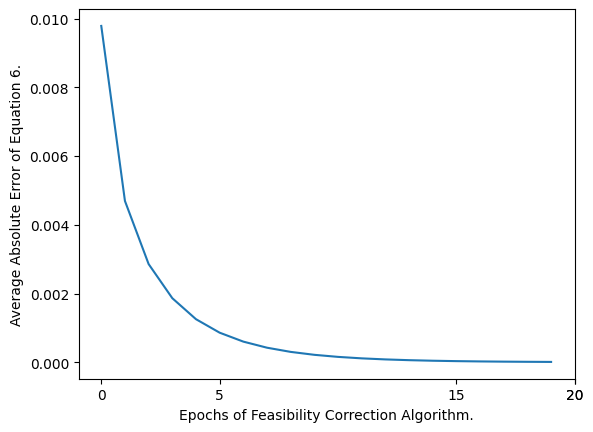

In [ ]:
plt.plot(pq_list)
plt.xticks([0,5,20,15,20])
plt.xlabel('Epochs of Feasibility Correction Algorithm.')
plt.ylabel('Average Absolute Error of Equation 6.')

In [ ]:
feasibility_validation(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf)

<tf.Tensor: shape=(1, 236), dtype=float32, numpy=
array([[-8.52871686e-02,  1.27372742e-02, -5.49595952e-02,
         4.69662696e-02,  1.26019050e-03, -4.55605686e-02,
         8.67824256e-03, -5.19090109e-02, -5.65248425e-04,
         1.12009048e-03,  4.09692526e-03, -6.87347651e-02,
        -1.72304213e-02, -2.32677683e-02, -1.11127615e-01,
        -4.95746285e-02, -1.80869699e-02, -1.02904260e-01,
         6.09308109e-02, -1.70849115e-02, -1.76177919e-03,
        -9.16516036e-03, -2.29102373e-03, -3.95163894e-04,
         7.71677494e-03,  8.89039040e-03, -1.30993068e-01,
        -2.51117945e-02, -3.10470015e-02, -5.15139895e-03,
         7.00473189e-02, -1.34352148e-02, -3.45088542e-03,
         6.76748902e-02, -5.82798719e-02,  6.16435185e-02,
        -5.53336111e-04, -6.43771933e-03, -3.58027965e-02,
        -6.93366528e-02, -1.11159682e-02,  1.67528927e-01,
        -1.53699964e-02,  2.52845287e-02,  6.30923510e-02,
         5.75264022e-02, -3.30552757e-02,  2.67128646e-03,
      

In [ ]:
idx = np.where(np.array(pred_opt_list)!=0)
np.mean(abs(np.array(pred_opt_list)[idx]-np.array(true_opt_list)[idx])/np.array(true_opt_list)[idx])
loss_per_list = (np.array(pred_opt_list)[idx]-np.array(true_opt_list)[idx])/np.array(pred_opt_list)[idx]
mean_value = np.mean(np.absolute(loss_per_list))
deviation = np.sqrt(np.sum(np.square(loss_per_list-mean_value))/len(loss_per_list))
#se = deviation/np.sqrt(len(loss_per_list))
print(np.mean(np.absolute(loss_per_list)))
print(deviation*1.96/np.sqrt(len(loss_per_list)))
#print(np.mean(feasibility_store_list))
#print(se)

0.01663588516198365
0.0008180609640269609


In [ ]:
def get_median(v):
    v = tf.reshape(v, [-1])
    m = v.get_shape()[0]//2
    return tf.reduce_min(tf.nn.top_k(v, m, sorted=False).values)
get_median(time_list)

<tf.Tensor: shape=(), dtype=float32, numpy=2.352854>

In [ ]:
import datetime
alpha_list = []
cost_list = []
objective_list = []
f_score_list = []
phy_score_list=[]

pred_opt_list = []
true_opt_list = []
pred_err = []
phy_err = []
gradient_list = []

condition_list = []
solution_p_list = []
solution_v_list = []
time_list = []
Y_bus_tf = tf.convert_to_tensor(Y_bus)
for ix in range(0,1000):
  print(ix)
  s_time = datetime.datetime.now()

  #For each scenario
  epsilon = -0.3
  t=0.0001
  condition = test_conditions[ix,:]
  condition_list.append(condition)
  p_condition = tf.convert_to_tensor(condition[0:grid_size].reshape([1,-1]))
  q_condition = tf.convert_to_tensor(condition[grid_size:grid_size*2].reshape([1,-1]))
  #get start point
  #gen_p_full,gen_q_full,n_vm,n_va = warmer([p_condition,q_condition])
  neigh_generation = knn_reression(neigh,condition.reshape([1,-1]))

  vm = neigh_generation[:,0:grid_size]
  #vm = np.ones([1,14])
  n_vm = normalize(vm,0.95,1.06)
  va = neigh_generation[:,grid_size:grid_size*2]
  #va = np.zeros([1,14])
  n_va = normalize(va,min_phi,max_phi)
  #gen_p = np.ones([1,5])
  gen_p=neigh_generation[:,grid_size*2:grid_size*2+gen_size]
  #gen_q = np.ones([1,5])
  gen_q=neigh_generation[:,grid_size*2+gen_size:grid_size*2+gen_size*2]
  gen_p_full = np.zeros(vm.shape)
  gen_q_full = np.zeros(vm.shape)
  k=0
  for m in range(0,grid_size):
    if m in gen_ids:
      gen_p_full[:,m]=gen_p[:,k]/baseMVA
      gen_q_full[:,m]=gen_q[:,k]/baseMVA
      k=k+1

  #best_list = []
  #pdb.set_trace()

  #n_demand_p = replaceinf(replacenan(normalize(p_condition,max_demand_p,min_demand_p)))
  #n_demand_q = replacenan(normalize(q_condition,max_demand_q,min_demand_p))
  n_vm_tf = tf.convert_to_tensor(n_vm)
  n_va_tf = tf.convert_to_tensor(n_va)
  gen_p_full_tf =tf.cast(tf.convert_to_tensor(gen_p_full),tf.float32)
  gen_q_full_tf = tf.cast(tf.convert_to_tensor(gen_q_full),tf.float32)
  #x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
  #alpha = np.zeros([1,1])
  best_cost = 0
  f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
  if f_score>epsilon:
    for k in range(0,200):
      '''Find good warm start point'''
      with tf.GradientTape(persistent=True) as tape:
        x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
        tape.watch(x_hat)
        f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        if f_score<0:
          break
        df_dp = tape.gradient(f_score,gen_p_full_tf)
        df_dq = tape.gradient(f_score,gen_q_full_tf)
        df_vm = tape.gradient(f_score,n_vm_tf)
        df_va = tape.gradient(f_score,n_va_tf)
        gen_p_full_tf = gen_p_full_tf-0.00001*replacenan(df_dp)
        gen_q_full_tf = gen_q_full_tf-0.000001*replacenan(df_dq)
        n_vm_tf = n_vm_tf-0.00000001*replacenan(df_vm)
        vm_tf = denormalize(n_vm_tf,0.95,1.06)
        n_va_tf = n_va_tf-0.000001*replacenan(df_va)
        #f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        print('trying to find start point,score=:'+str(f_score))

  df_dp = None
  df_dq = None
  df_vm = None
  df_va = None
  beta = 0.6
  for j in range(0,5000):
    with tf.GradientTape(persistent=True) as tape:
      if t<100:
        t=t*10
      #pdb.set_trace()
      x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
      tape.watch(x_hat)
      financial_cost1=tf.cast(tf.math.multiply(gen_p_full_tf*100, c1_full),tf.float32)
      financial_cost2=tf.math.multiply(K.square(tf.cast(gen_p_full_tf*100,tf.float32)), c2_full)
      financial_cost = financial_cost1+financial_cost2
      print(tf.reduce_sum(financial_cost1+financial_cost2,axis=1))

      #f_score = feasibility_validation(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf)
      f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
      #pdb.set_trace()

      #pred_err.append(f_score.numpy())

      f_score_constraint = f_score-epsilon
      vm_tf = denormalize(n_vm_tf,0.95,1.06)
      va_tf = denormalize(n_va_tf,min_phi,max_phi)
      objective = tf.reduce_sum(financial_cost)+1/t*tf.math.log(-f_score_constraint)
      df_dx = tape.gradient(objective,x_hat)
      if df_dp is None:
        df_dp = df_dx[4]
      else:
        df_dp = df_dp*(1-beta)+df_dx[4]
      #tape.gradient(objective,gen_p_full_tf)
      if df_dq is None:
        df_dq = df_dx[5]
      else:
        df_dq = df_dq*(1-beta)+df_dx[5]
      if df_vm is None:
        df_vm = df_dx[2]
      else:
        df_vm = df_vm*(1-beta)+df_dx[2]
      if df_va is None:
        df_va = df_dx[3]
      else:
        df_va = df_va*(1-beta)+df_dx[3]
      #tape.gradient(objective,n_vm_tf)
      #df_va = df_dx[3]
      #tape.gradient(objective,n_va_tf)
      #pdb.set_trace()
      gen_p_full_tf = gen_p_full_tf-0.0000001*df_dp
      f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
      f_score_constraint = f_score-epsilon
      #alpha_1 = tf.reduce_mean((replaceinf(1/(t*(gen_p_full_tf)))-replaceinf(1/(t*(tf_p_upper-gen_p_full_tf)))-replacenan((2*c2_full*10000-c1_full*100)/replacenan(df_dp))))
      '''objective_1 = tf.reduce_sum(financial_cost)+\
                    replaceinf(1/t*tf.math.log(-f_score_constraint))'''
                    #+replaceinf(1/t*tf.math.log(tf_q_upper-gen_q_full_tf))+replaceinf(1/t*tf.math.log(gen_q_full_tf-tf_q_lower))\
                    #+tf.cast(1/t*tf.math.log(1.06-vm_tf)+1/t*tf.math.log(vm_tf-0.95),dtype=tf.float32)
      gen_q_full_tf = gen_q_full_tf-0.0000001*df_dq
      n_vm_tf = n_vm_tf-0.000001*df_vm
      vm_tf = denormalize(n_vm_tf,0.95,1.06)
      n_va_tf = n_va_tf-0.000001*df_va


      f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
      if f_score<epsilon:
        best_cost = tf.reduce_sum(financial_cost1+financial_cost2,axis=1).numpy()[0]
      else:
        break
  #Calculate the power, gradient descent on voltage
  df_dp = None
  df_dq = None
  df_vm = None
  df_va = None
  pq_demand = tf.cast(tf.concat([p_condition,q_condition],axis=1),tf.float32)
  #get voltage on each bus
  vm = denormalize(n_vm_tf,0.95,1.06)
  local_phi = denormalize(n_va_tf,np.min(phi),np.max(phi))

  #v_r = tf.math.multiply(vm,tf.cos(tf.math.multiply(local_phi,\
  #                                                            tf.constant(math.pi/180,dtype='float64'))))
  #v_i = tf.math.multiply(vm,tf.sin(tf.math.multiply(local_phi,\
  #                                                            tf.constant(math.pi/180,dtype='float64'))))

  for k in range(0,100):
    with tf.GradientTape(persistent=True) as t:
      cali_x = [gen_p_full_tf,gen_q_full_tf,vm,local_phi]
      t.watch(cali_x)
      v_r = tf.math.multiply(vm,app_cos(local_phi))
      v_i = tf.math.multiply(vm,app_sin(local_phi))
      V = tf.cast(tf.reshape(tf.complex(v_r,v_i),[-1,grid_size]),tf.complex64)
      gen_p_full_tf = gen_p_full_tf*gen_pos

      #pdb.set_trace()

      I = tf.matmul(V,Y_bus_tf)
      S_in = tf.math.multiply(V,tf.math.conj(I))
      P_in = tf.math.real(S_in)
      Q_in = tf.math.imag(S_in)
      gen_q_full_tf = Q_in+tf.cast(q_condition,tf.float32)
      gen_q_full_tf = gen_q_full_tf*gen_pos
      PQ_out = pq_demand-tf.concat([gen_p_full_tf,gen_q_full_tf],axis=1)
      PQ_balance = tf.math.reduce_mean(tf.abs(tf.concat([P_in,Q_in],axis=1)+PQ_out))
      df_dcali = t.gradient(PQ_balance,cali_x)
      beta1 = 0.5
      #if df_dp is None:
      #  df_dp = df_dcali[0]
      #else:
      #  df_dp = df_dp*(1-beta1)+df_dcali[0]
      #tape.gradient(objective,gen_p_full_tf)
      if df_dq is None:
        df_dq = df_dcali[1]
      else:
        df_dq = df_dq*(1-beta1)+df_dcali[1]
      if df_vm is None:
        df_vm = df_dcali[2]
      else:
        df_vm = df_vm*(1-beta1)+df_dcali[2]
      if df_va is None:
        df_va = df_dcali[3]
      else:
        df_va = df_va*(1-beta1)+df_dcali[3]
      #gen_p_full_tf =gen_p_full_tf-0.01*df_dp
      #gen_p_full_tf-0.01*df_dp
      #tf.minimum(tf.maximum(gen_p_full_tf-0.01*df_dp,0),tf_p_upper)
      #gen_q_full_tf = tf.minimum(tf.maximum(gen_q_full_tf-0.1*df_dq,tf_q_lower),tf_q_upper)
      #gen_q_full_tf-0.01*df_dq
      #tf.minimum(tf.maximum(gen_q_full_tf-0.01*df_dq,tf_q_lower),tf_q_upper)
      vm = tf.minimum(tf.maximum(vm-0.0001*df_vm*abs(gen_pos-1),0.95),1.06)
      local_phi = local_phi-0.2*df_va
      if(PQ_balance<0.01):
        financial_cost1=tf.cast(tf.math.multiply(gen_p_full_tf*100, c1_full),tf.float32)
        financial_cost2=tf.math.multiply(K.square(tf.cast(gen_p_full_tf*100,tf.float32)), c2_full)
        financial_cost = tf.reduce_sum(financial_cost1+financial_cost2)
        best_cost = financial_cost
        break
      print(PQ_balance)
  #best 0.1,0.1


  #end_time = datetime.datetime.now()
  e_time = datetime.datetime.now()
  dur = e_time-s_time
  solution_p_list.append(gen_p_full_tf.numpy().flatten())
  solution_v_list.append(vm_tf.numpy().flatten())
  pred_opt_list.append(best_cost)
  true_opt_list.append(optimality_validation(ix))
  print(dur.total_seconds())
  time_list.append(dur.total_seconds())
  #physical = feasibility_validation(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf)
  #phy_score_list.append(np.mean(abs(np.array(physical))))

0
tf.Tensor([130365.03], shape=(1,), dtype=float32)
tf.Tensor([130283.125], shape=(1,), dtype=float32)
tf.Tensor([130168.516], shape=(1,), dtype=float32)
tf.Tensor([130040.86], shape=(1,), dtype=float32)
tf.Tensor([129908.06], shape=(1,), dtype=float32)
tf.Tensor([129773.266], shape=(1,), dtype=float32)
tf.Tensor([129637.734], shape=(1,), dtype=float32)
tf.Tensor([129501.95], shape=(1,), dtype=float32)
tf.Tensor([129366.13], shape=(1,), dtype=float32)
tf.Tensor([129230.35], shape=(1,), dtype=float32)
tf.Tensor([129094.66], shape=(1,), dtype=float32)
tf.Tensor([128959.03], shape=(1,), dtype=float32)
tf.Tensor([128823.5], shape=(1,), dtype=float32)
tf.Tensor([128688.05], shape=(1,), dtype=float32)
tf.Tensor([128552.695], shape=(1,), dtype=float32)
tf.Tensor([128417.43], shape=(1,), dtype=float32)
tf.Tensor([128282.266], shape=(1,), dtype=float32)
tf.Tensor([128147.18], shape=(1,), dtype=float32)
tf.Tensor([128012.17], shape=(1,), dtype=float32)
tf.Tensor([127877.266], shape=(1,), dtype=f

tf.Tensor(0.45097187, shape=(), dtype=float32)
tf.Tensor(0.45041078, shape=(), dtype=float32)
tf.Tensor(0.44964513, shape=(), dtype=float32)
tf.Tensor(0.44926274, shape=(), dtype=float32)
tf.Tensor(0.44928387, shape=(), dtype=float32)
tf.Tensor(0.448975, shape=(), dtype=float32)
tf.Tensor(0.4485475, shape=(), dtype=float32)
tf.Tensor(0.4487549, shape=(), dtype=float32)
tf.Tensor(0.44824454, shape=(), dtype=float32)
tf.Tensor(0.44815725, shape=(), dtype=float32)
tf.Tensor(0.4479645, shape=(), dtype=float32)
tf.Tensor(0.44780397, shape=(), dtype=float32)
tf.Tensor(0.447791, shape=(), dtype=float32)
tf.Tensor(0.44749787, shape=(), dtype=float32)
tf.Tensor(0.44770136, shape=(), dtype=float32)
tf.Tensor(0.4474536, shape=(), dtype=float32)
tf.Tensor(0.44752958, shape=(), dtype=float32)
tf.Tensor(0.44723183, shape=(), dtype=float32)
tf.Tensor(0.44714916, shape=(), dtype=float32)
tf.Tensor(0.44709945, shape=(), dtype=float32)
tf.Tensor(0.44716322, shape=(), dtype=float32)
tf.Tensor(0.44700307,

KeyboardInterrupt: ignored

In [ ]:
gen_q_full_tf

<tf.Tensor: shape=(1, 118), dtype=float32, numpy=
array([[ 0.07068242, -0.        ,  0.        ,  0.71110713, -0.        ,
         0.31968266, -0.        , -0.84121394, -0.        , -1.1575694 ,
        -0.        ,  0.5733786 , -0.        , -0.        ,  0.12983817,
         0.        ,  0.        ,  0.21055086,  0.3021005 , -0.        ,
         0.        , -0.        ,  0.        , -0.19187106, -0.48495737,
        -0.32270283,  0.12799789, -0.        ,  0.        , -0.        ,
         0.1743487 ,  0.23402514,  0.        , -0.13138315,  0.        ,
         0.13106336,  0.        , -0.        , -0.        ,  0.27682447,
        -0.        ,  0.20883384, -0.        , -0.        ,  0.        ,
        -0.1025951 ,  0.        , -0.        ,  0.19824252, -0.        ,
        -0.        ,  0.        , -0.        ,  0.22484192,  0.26331517,
         0.1586654 , -0.        ,  0.        ,  0.82930684, -0.        ,
         0.33982408,  0.00256175, -0.        ,  0.        , -0.4607017 ,
 

In [ ]:
#NR method
import datetime
alpha_list = []
cost_list = []
objective_list = []
f_score_list = []
phy_score_list=[]

pred_opt_list = []
true_opt_list = []
pred_err = []
phy_err = []
gradient_list = []

condition_list = []
solution_p_list = []
solution_v_list = []
time_list = []
Y_bus_tf = tf.convert_to_tensor(Y_bus)
for ix in range(1,2):
  print(ix)
  s_time = datetime.datetime.now()

  #For each scenario
  epsilon = 0.5
  t=0.0001
  condition = test_conditions[ix,:]
  condition_list.append(condition)
  p_condition = tf.convert_to_tensor(condition[0:grid_size].reshape([1,-1]))
  q_condition = tf.convert_to_tensor(condition[grid_size:grid_size*2].reshape([1,-1]))
  #get start point
  #gen_p_full,gen_q_full,n_vm,n_va = warmer([p_condition,q_condition])
  neigh_generation = knn_reression(neigh,condition.reshape([1,-1]))

  vm = neigh_generation[:,0:grid_size]
  #vm = np.ones([1,14])
  n_vm = normalize(vm,0.95,1.06)
  va = neigh_generation[:,grid_size:grid_size*2]
  #va = np.zeros([1,14])
  n_va = normalize(va,min_phi,max_phi)
  #gen_p = np.ones([1,5])
  gen_p=neigh_generation[:,grid_size*2:grid_size*2+gen_size]
  #gen_q = np.ones([1,5])
  gen_q=neigh_generation[:,grid_size*2+gen_size:grid_size*2+gen_size*2]
  gen_p_full = np.zeros(vm.shape)
  gen_q_full = np.zeros(vm.shape)
  k=0
  for m in range(0,grid_size):
    if m in gen_ids:
      gen_p_full[:,m]=gen_p[:,k]/baseMVA
      gen_q_full[:,m]=gen_q[:,k]/baseMVA
      k=k+1

  #best_list = []
  #pdb.set_trace()

  #n_demand_p = replaceinf(replacenan(normalize(p_condition,max_demand_p,min_demand_p)))
  #n_demand_q = replacenan(normalize(q_condition,max_demand_q,min_demand_p))
  n_vm_tf = tf.convert_to_tensor(n_vm)
  n_va_tf = tf.convert_to_tensor(n_va)
  gen_p_full_tf =tf.cast(tf.convert_to_tensor(gen_p_full),tf.float32)
  gen_q_full_tf = tf.cast(tf.convert_to_tensor(gen_q_full),tf.float32)
  #x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
  #alpha = np.zeros([1,1])
  best_cost = 0
  f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
  if f_score>epsilon:
    for k in range(0,200):
      '''Find good warm start point'''
      with tf.GradientTape(persistent=True) as tape:
        x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
        tape.watch(x_hat)
        f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        if f_score<0:
          break
        df_dp = tape.gradient(f_score,gen_p_full_tf)
        df_dq = tape.gradient(f_score,gen_q_full_tf)
        df_vm = tape.gradient(f_score,n_vm_tf)
        df_va = tape.gradient(f_score,n_va_tf)
        gen_p_full_tf = gen_p_full_tf-0.00001*replacenan(df_dp)
        gen_q_full_tf = gen_q_full_tf-0.000001*replacenan(df_dq)
        n_vm_tf = n_vm_tf-0.00000001*replacenan(df_vm)
        vm_tf = denormalize(n_vm_tf,0.95,1.06)
        n_va_tf = n_va_tf-0.000001*replacenan(df_va)
        #f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
        print('trying to find start point,score=:'+str(f_score))

  df_dp = None
  df_dq = None
  df_vm = None
  df_va = None
  beta = 0.6
  for j in range(0,5000):
    with tf.GradientTape(persistent=True) as tape:
      if t<100:
        t=t*10
      #pdb.set_trace()
      x_hat = [p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf]
      tape.watch(x_hat)
      financial_cost1=tf.cast(tf.math.multiply(gen_p_full_tf*100, c1_full),tf.float32)
      financial_cost2=tf.math.multiply(K.square(tf.cast(gen_p_full_tf*100,tf.float32)), c2_full)
      financial_cost = financial_cost1+financial_cost2
      print(tf.reduce_sum(financial_cost1+financial_cost2,axis=1))

      #f_score = feasibility_validation(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf)
      f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
      #pdb.set_trace()

      #pred_err.append(f_score.numpy())

      f_score_constraint = f_score-epsilon
      vm_tf = denormalize(n_vm_tf,0.95,1.06)
      va_tf = denormalize(n_va_tf,min_phi,max_phi)
      objective = tf.reduce_sum(financial_cost)+1/t*tf.math.log(-f_score_constraint)
      df_dx = tape.gradient(objective,x_hat)
      if df_dp is None:
        df_dp = df_dx[4]
      else:
        df_dp = df_dp*(1-beta)+df_dx[4]
      #tape.gradient(objective,gen_p_full_tf)
      if df_dq is None:
        df_dq = df_dx[5]
      else:
        df_dq = df_dq*(1-beta)+df_dx[5]
      if df_vm is None:
        df_vm = df_dx[2]
      else:
        df_vm = df_vm*(1-beta)+df_dx[2]
      if df_va is None:
        df_va = df_dx[3]
      else:
        df_va = df_va*(1-beta)+df_dx[3]
      #tape.gradient(objective,n_vm_tf)
      #df_va = df_dx[3]
      #tape.gradient(objective,n_va_tf)
      #pdb.set_trace()
      gen_p_full_tf = gen_p_full_tf-0.0000001*df_dp
      f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
      f_score_constraint = f_score-epsilon
      #alpha_1 = tf.reduce_mean((replaceinf(1/(t*(gen_p_full_tf)))-replaceinf(1/(t*(tf_p_upper-gen_p_full_tf)))-replacenan((2*c2_full*10000-c1_full*100)/replacenan(df_dp))))
      '''objective_1 = tf.reduce_sum(financial_cost)+\
                    replaceinf(1/t*tf.math.log(-f_score_constraint))'''
                    #+replaceinf(1/t*tf.math.log(tf_q_upper-gen_q_full_tf))+replaceinf(1/t*tf.math.log(gen_q_full_tf-tf_q_lower))\
                    #+tf.cast(1/t*tf.math.log(1.06-vm_tf)+1/t*tf.math.log(vm_tf-0.95),dtype=tf.float32)
      gen_q_full_tf = gen_q_full_tf-0.0000001*df_dq
      n_vm_tf = n_vm_tf-0.000001*df_vm
      vm_tf = denormalize(n_vm_tf,0.95,1.06)
      n_va_tf = n_va_tf-0.000001*df_va


      f_score = model_g([p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf])
      if f_score<epsilon:
        best_cost = tf.reduce_sum(financial_cost1+financial_cost2,axis=1).numpy()[0]
      else:
        break
  #Calculate the power, gradient descent on voltage
  df_dp = None
  df_dq = None
  df_vm = None
  df_va = None
  pq_demand = tf.cast(tf.concat([p_condition,q_condition],axis=1),tf.float32)
  #get voltage on each bus
  vm = denormalize(n_vm_tf,0.95,1.06)
  local_phi = denormalize(n_va_tf,np.min(phi),np.max(phi))

  #v_r = tf.math.multiply(vm,tf.cos(tf.math.multiply(local_phi,\
  #                                                            tf.constant(math.pi/180,dtype='float64'))))
  #v_i = tf.math.multiply(vm,tf.sin(tf.math.multiply(local_phi,\
  #                                                            tf.constant(math.pi/180,dtype='float64'))))

  for k in range(0,10):
    with tf.GradientTape(persistent=True) as t:
      vm = tf.reshape(vm,grid_size)
      local_phi = tf.reshape(local_phi,grid_size)
      cali_x = [local_phi,vm]
      t.watch(cali_x)
      v_r = tf.math.multiply(vm,app_cos(local_phi))
      v_i = tf.math.multiply(vm,app_sin(local_phi))
      V = tf.cast(tf.reshape(tf.complex(v_r,v_i),[-1,grid_size]),tf.complex64)
      I = tf.matmul(V,Y_bus_tf)
      S_in = tf.math.multiply(V,tf.math.conj(I))
      P_in = tf.math.real(S_in)
      Q_in = tf.math.imag(S_in)
      if k!=0:
        gen_q_full_tf = Q_in+tf.cast(q_condition,tf.float32)
      gen_p_full_tf = gen_p_full_tf*gen_pos
      gen_q_full_tf = gen_q_full_tf*gen_pos
      #gen_q_full_tf = tf.minimum(tf.maximum(gen_q_full_tf,tf_q_lower),tf_q_upper)
      PQ_out = pq_demand-tf.concat([gen_p_full_tf,gen_q_full_tf],axis=1)
      PQ_balance = tf.reshape(tf.concat([P_in,Q_in],axis=1)+PQ_out,grid_size*2)
      df_dcali = t.jacobian(PQ_balance,cali_x) #each one is 236*118
      #pdb.set_trace()
      jacobian = tf.concat([df_dcali[0],df_dcali[1]],axis=1)
      j_inverse = tf.linalg.pinv(jacobian)
      delta_phi_v = tf.matmul(j_inverse,tf.reshape(tf.cast(PQ_balance,tf.float64),[grid_size*2,1]))
      local_phi = local_phi-delta_phi_v[:grid_size,0]
      vm =  vm-delta_phi_v[grid_size:,0]
      print(np.mean(abs(PQ_balance)))
      #pdb.set_trace()
      '''beta1 = 0.5
      if df_dp is None:
        df_dp = df_dcali[0]
      else:
        df_dp = df_dp*(1-beta1)+df_dcali[0]
      #tape.gradient(objective,gen_p_full_tf)
      if df_dq is None:
        df_dq = df_dcali[1]
      else:
        df_dq = df_dq*(1-beta1)+df_dcali[1]
      if df_vm is None:
        df_vm = df_dcali[2]
      else:
        df_vm = df_vm*(1-beta1)+df_dcali[2]
      if df_va is None:
        df_va = df_dcali[3]
      else:
        df_va = df_va*(1-beta1)+df_dcali[3]
      #gen_p_full_tf =gen_p_full_tf-0.01*df_dp
      #gen_p_full_tf-0.01*df_dp
      #tf.minimum(tf.maximum(gen_p_full_tf-0.01*df_dp,0),tf_p_upper)
      gen_q_full_tf = tf.minimum(tf.maximum(gen_q_full_tf-0.1*df_dq,tf_q_lower),tf_q_upper)
      #gen_q_full_tf-0.01*df_dq
      #tf.minimum(tf.maximum(gen_q_full_tf-0.01*df_dq,tf_q_lower),tf_q_upper)
      local_phi = local_phi-0.1*df_va
      if(PQ_balance<0.001):
        financial_cost1=tf.cast(tf.math.multiply(gen_p_full_tf*100, c1_full),tf.float32)
        financial_cost2=tf.math.multiply(K.square(tf.cast(gen_p_full_tf*100,tf.float32)), c2_full)
        financial_cost = tf.reduce_sum(financial_cost1+financial_cost2)
        best_cost = financial_cost
        break
      print(PQ_balance)'''
  #best 0.1,0.1


  #end_time = datetime.datetime.now()
  e_time = datetime.datetime.now()
  dur = e_time-s_time
  solution_p_list.append(gen_p_full_tf.numpy().flatten())
  solution_v_list.append(vm_tf.numpy().flatten())
  pred_opt_list.append(best_cost)
  true_opt_list.append(optimality_validation(ix))
  print(dur.total_seconds())
  time_list.append(dur.total_seconds())
  #physical = feasibility_validation(p_condition,q_condition,n_vm_tf,n_va_tf,gen_p_full_tf,gen_q_full_tf)
  #phy_score_list.append(np.mean(abs(np.array(physical))))

In [ ]:
import pickle
file_name='/content/drive/MyDrive/Phd/opf_icnn/model_data'
fileObject = open(file_name,'wb')
pickle.dump(time_list,fileObject)
fileObject.close()

<tf.Tensor: shape=(), dtype=float32, numpy=5.336169>

In [ ]:
bb = [x/1.5 for x in time_list if x <= 24]

In [ ]:
get_median(bb)

<tf.Tensor: shape=(), dtype=float32, numpy=0.61208>

In [ ]:
np.mean(np.array(bb))

0.6218236470588235

In [ ]:
time_list

[2.455134,
 4.939876,
 2.469643,
 2.355895,
 2.660353,
 5.865799,
 2.199636,
 2.568598,
 4.451071,
 3.547916,
 2.501593,
 2.389276,
 2.351216,
 3.0548,
 4.654235,
 5.112047,
 6.72462,
 2.579672,
 2.526128,
 2.55499,
 2.330501,
 4.493833,
 3.58491,
 3.366374,
 2.441672,
 4.256029,
 2.603435,
 2.570605,
 2.353949,
 2.49364,
 5.261509,
 2.931727,
 2.581688,
 2.198024,
 4.862461,
 5.530288,
 2.676871,
 4.886583,
 3.426235,
 5.598943,
 4.672188,
 3.277525,
 2.420926,
 4.05423,
 2.287469,
 4.474505,
 2.615977,
 2.305153,
 4.744281,
 4.916073,
 2.352747,
 3.489173,
 2.625516,
 4.09606,
 4.558221,
 4.778861,
 5.838261,
 2.651055,
 2.537798,
 2.662871,
 5.201847,
 5.505383,
 3.279864,
 5.482296,
 2.638836,
 2.281375,
 2.463096,
 3.369681,
 5.548709,
 2.336348,
 2.410115,
 4.21133,
 4.378755,
 2.504125,
 2.328865,
 3.411824,
 5.389278,
 2.426591,
 4.601883,
 2.455193,
 5.59673,
 3.945426,
 3.735206,
 6.228573,
 5.596448,
 2.77442,
 4.396222,
 2.630219,
 2.661395,
 3.484341,
 3.653605,
 4.509086,

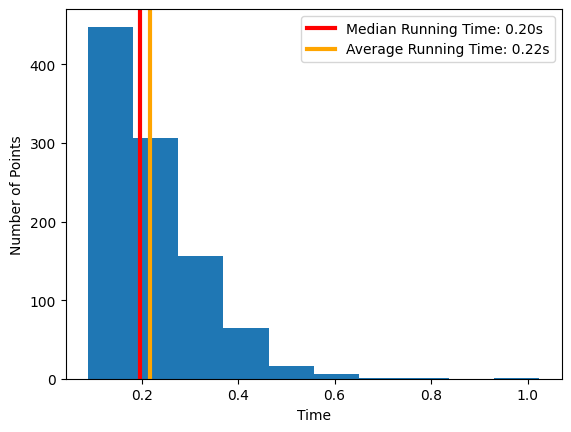

In [ ]:
plt.hist(bb)
plt.axvline(get_median(bb),color='red',lw=3,label=f'Median Running Time: {get_median(bb):,.2f}s')
plt.axvline(np.mean(np.array(bb)),color='orange',lw=3,label=f'Average Running Time: {np.mean(np.array(bb)):,.2f}s')

plt.xlabel('Time')
plt.ylabel('Number of Points')
plt.legend()

In [ ]:
local_phi = denormalize(n_va_tf,np.min(phi),np.max(phi))
#pdb.set_trace()
PQ_out = tf.cast(tf.concat([p_condition,q_condition],axis=1),tf.float32)-tf.concat([gen_p_full_tf,gen_q_full_tf],axis=1)

#get voltage on each bus
v_r = tf.math.multiply(vm,tf.cos(tf.math.multiply(local_phi,\
                                                            tf.constant(math.pi/180,dtype='float64'))))
v_i = tf.math.multiply(vm,tf.sin(tf.math.multiply(local_phi,\
                                                            tf.constant(math.pi/180,dtype='float64'))))
V = tf.cast(tf.reshape(tf.complex(v_r,v_i),[-1,grid_size]),tf.complex64)
#if i==1:
#  pdb.set_trace()
#calculate current
Y_bus_tf = tf.convert_to_tensor(Y_bus)
I = tf.matmul(V,Y_bus_tf)

#calculate power injection on each bus
S_in = tf.math.multiply(V,tf.math.conj(I))
P_in = tf.math.real(S_in)
Q_in = tf.math.imag(S_in)
#pdb.set_trace()
#evaluate the balance
PQ_balance = tf.math.reduce_mean(tf.square(tf.concat([P_in,Q_in],axis=1)+PQ_out))

NameError: ignored

In [ ]:
PQ_balance

<tf.Tensor: shape=(), dtype=float32, numpy=0.05363249>

In [ ]:
phy_score_list

[]

In [ ]:
np.mean(phy_score_list)

0.16039905

In [ ]:
idx = np.where(np.array(pred_opt_list)!=0)
np.mean(abs(np.array(pred_opt_list)[idx]-np.array(true_opt_list)[idx])/np.array(true_opt_list)[idx])

0.020518232762645066

In [ ]:
pd.DataFrame(condition_list).to_csv('demand.csv')
pd.DataFrame(solution_p_list).to_csv('p_solution.csv')
pd.DataFrame(solution_v_list).to_csv('v_solution.csv')

In [ ]:
solution_p_list

[array([ 0.35036695,  0.        ,  0.        ,  0.31018975,  0.        ,
         0.4102073 ,  0.        ,  0.32375625,  0.        ,  3.0937076 ,
         0.        ,  0.8942642 , -0.        ,  0.        ,  0.3722916 ,
         0.        ,  0.        ,  0.45895916,  0.44390306,  0.        ,
         0.        ,  0.        , -0.        ,  0.52246004,  1.3278997 ,
         1.5886489 ,  0.31487948,  0.        ,  0.        , -0.        ,
         0.06202701,  0.36099872,  0.        ,  0.36903563,  0.        ,
         0.3251776 , -0.        ,  0.        ,  0.        ,  0.46809602,
         0.        ,  0.47163293,  0.        ,  0.        , -0.        ,
         0.22393247,  0.        ,  0.        ,  1.317021  ,  0.        ,
         0.        , -0.        ,  0.        ,  0.519829  ,  0.4769376 ,
         0.30526233,  0.        , -0.        ,  0.7942586 ,  0.        ,
         1.2159449 ,  0.38257542,  0.        ,  0.        ,  2.5641026 ,
         2.6598985 ,  0.        ,  0.        ,  3.3

In [ ]:
np.mean(np.array(phy_score_list)[np.array(pred_opt_list)!=0])

IndexError: ignored

In [ ]:
np.array(pred_opt_list)[np.where(np.array(pred_opt_list)!=0)]

array([ 129344.92 ,  126584.77 ,  128819.91 ,  129274.164,  132518.03 ,
        129588.17 ,  128794.53 ,  127437.56 ,  132778.2  ,  129874.03 ,
        127540.02 ,  132140.67 ,  127836.086,  128813.695,  130685.836,
        129349.625,  130794.305,  129087.76 ,  129068.06 ,  131983.98 ,
        129310.13 ,  128026.945,  129912.2  ,  126140.92 ,  129125.125,
        132567.11 ,  126856.33 ,  129657.75 ,  130339.234,  129953.17 ,
        133691.31 ,  131241.9  ,  133478.8  ,  129760.66 ,  130769.27 ,
        131071.625,  131292.44 ,  131562.6  ,  130238.016,  129541.09 ,
        130671.984,  128525.234,  128014.16 ,  126520.36 ,  127733.84 ,
        130852.96 ,  131061.375,  130808.66 ,  130256.78 ,  128037.48 ,
        131124.88 ,  130928.625,  129051.836,  132938.72 ,  133090.84 ,
        130285.87 ,  133127.22 ,  135431.83 ,  127495.3  ,  131997.25 ,
        132051.45 ,  131373.22 ,  132620.86 ,  129332.38 ,  129116.92 ,
        132010.23 ,  126090.836,  129783.2  ,  126719.266,  1300

In [ ]:
np.array(true_opt_list)

array([124627.31047068, 122893.59612836, 124299.95602211, 124837.00898312,
       127749.39820412, 125481.04367802, 124838.82728554, 122612.23434018,
       129096.68212964, 125522.46682722, 123057.57153818, 128326.75107093,
       123512.11600083, 124994.17264628, 125437.58257728, 123754.50799387,
       127373.11656933, 123803.68949957, 125761.08789463, 127663.73408289,
       124428.59274042, 123771.20915938, 125464.01333448, 121031.6966759 ,
       126082.20344047, 128670.89800234, 122868.65235555, 125836.2440702 ,
       126219.935582  , 125153.61632674, 129201.58613266, 127509.79899726,
       126936.5811112 , 124749.0768721 , 125315.33097272, 126095.24506272,
       126985.68398937, 127995.5020018 , 124849.77960736, 125717.24330478,
       127435.4663001 , 124567.18373093, 123148.11262585, 122572.24959237,
       123429.65122293, 126608.0165244 , 127543.8968053 , 126029.14154494,
       125840.86975245, 124538.43351842, 127844.48760918, 126078.27823165,
       125820.96096625, 1

In [ ]:
np.array(true_opt_list)

array([6835.68417534, 8249.22032065, 7472.61878282, 8246.791557  ,
       8196.1087432 , 8205.67661374, 7157.2188352 , 8152.43903098,
       8434.48537098, 8479.14896971, 6843.59677137, 7464.78738884,
       7235.35212545, 8178.36366907, 7453.32821405, 7839.18581908,
       7815.11038952, 7239.31336746, 7906.97142618, 8580.15067348,
       8317.53492727, 8129.97636733, 8530.14691136, 8405.16936694,
       8438.13932858, 8244.83436032, 7266.28955719, 7588.38169114,
       7249.56744541, 8927.95781984, 8181.42531881, 6805.05782522,
       6991.73342148, 7779.91895293, 8038.47660695, 7632.24863288,
       8973.78709022, 6964.63879131, 7414.39053099, 7967.5032603 ,
       7513.02187385, 9074.95174002, 8446.68717366, 8051.32434593,
       7815.95148446, 7151.46244784, 7594.25626234, 7915.66808328,
       8066.25222616, 7321.28319029, 7820.20742352, 7350.50367736,
       8463.10675773, 7678.6381891 , 7952.88905863, 9156.10612486,
       8400.00459927, 8931.08139851, 8896.47089447, 8636.50765

In [ ]:
q_lower_constraint

<tf.Tensor: shape=(1, 14), dtype=float32, numpy=
array([[-0.01, -0.41, -0.01,  0.  ,  0.  , -0.07,  0.  , -0.07,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ]], dtype=float32)>

In [ ]:
f_score

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[ 5.92760220e-02, -2.55170465e-03,  3.67432684e-02,
         4.66445759e-02,  3.31202820e-02,  3.27892452e-02,
         3.50692682e-02,  3.71335894e-02,  3.25445309e-02,
         2.06079185e-02,  2.32498609e-02,  1.77039281e-02,
         3.52146849e-02,  2.97211111e-03, -5.09287119e-02,
        -6.31466508e-03,  3.50459740e-02, -1.12998709e-02,
         1.08804628e-02,  1.13536119e-02, -1.03765279e-02,
         1.16605535e-02, -8.54653120e-03,  1.39900148e-02,
        -3.87421809e-03, -1.24906898e-02, -2.74914689e-03,
         2.70605087e-05]], dtype=float32)>

In [ ]:
alpha

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[1114.4065 , 6253.9946 , 4386.453  ,  107.19471, 5142.559  ,
        1494.2617 , 2848.4863 , 4392.7363 , 2080.2336 ,    0.     ,
           0.     ,    0.     ,  359.12967,    0.     ,    0.     ,
           0.     ,  421.2955 ,    0.     ,    0.     ,    0.     ,
           0.     ,    0.     ,    0.     ,    0.     ,    0.     ,
           0.     ,    0.     ,    0.     ]], dtype=float32)>

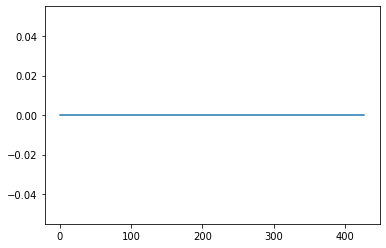

In [ ]:
plt.plot(np.array(alpha_list).reshape([-1,28])[:,0])

In [ ]:
financial_cost

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([7413.48], dtype=float32)>

In [ ]:
optimality_validation(ix)

6835.684175335235

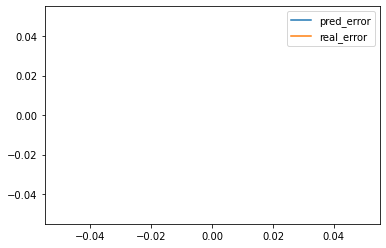

In [ ]:
plt.plot(np.matrix.flatten(np.array(pred_err[:])))
plt.plot(np.matrix.flatten(np.array(phy_err[:])))
plt.legend(['pred_error','real_error'])

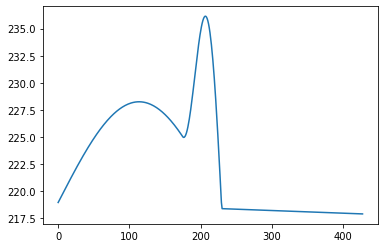

In [ ]:
plt.plot(np.array(gradient_list[:]).flatten())

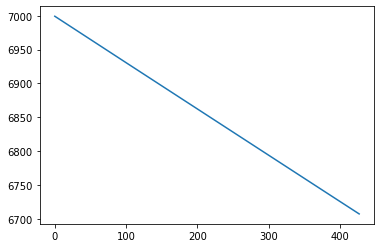

In [ ]:
plt.plot(np.array(cost_list).flatten()[:])

In [ ]:
objective_list[0]

array([6999.1562], dtype=float32)

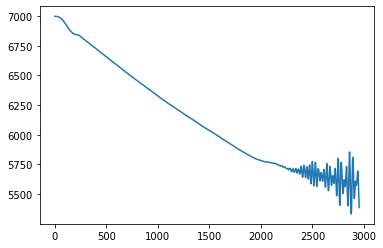

In [ ]:
plt.plot(np.array(objective_list).flatten()[:])

In [ ]:
financial_cost

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([8686.109], dtype=float32)>

In [ ]:
alpha = np.zeros_like(f_score_constraint)
objective = financial_cost+alpha*(f_score_constraint)

In [ ]:
f_score_constraint

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.05587591]], dtype=float32)>

In [ ]:
x_grad

[<tf.Tensor: shape=(1, 14), dtype=float64, numpy=
 array([[-50.61537933,  36.52884674,  65.26776886,  68.9239502 ,
         -12.83524227, -92.49980927,   4.05047226,  50.06132126,
          74.19652557, -77.0694046 ,   5.60108948, -11.76787567,
          19.27180481,  43.51996613]])>,
 <tf.Tensor: shape=(1, 14), dtype=float64, numpy=
 array([[  13.51648712,   -1.69207764,  -97.18936157,  -94.25988007,
         -134.2250824 ,  -66.37012482,  -12.00244904,  -30.8514061 ,
           13.46759033, -105.60745239,  -93.34931183, -175.72085571,
          -57.85305023, -169.0920105 ]])>,
 None,
 None,
 None,
 None]

In [ ]:
aa = barrier_function(t,gen_q_full_tf-tf_q_upper)
aa[tf.where()]=0
print(aa)

TypeError: ignored

In [ ]:
replaceinf(barrier_function(t,gen_q_full_tf-tf_q_upper))

InvalidArgumentError: ignored

In [ ]:
barrier_function(t,tf.cast(gen_p_full_tf-tf_p_upper,tf.float32))

InvalidArgumentError: ignored

In [ ]:
tf.math.log(-1.0*u)

<tf.Tensor: shape=(1, 14), dtype=float64, numpy=
array([[-11.34347558,  -2.2430802 ,  -1.09773881,  -1.26230226,
         -1.30665163, -10.20437154,  -2.39002535, -10.79256254,
         -2.18227443,  -1.83472753,  -2.14317668,  -2.06385651,
         -1.77096381,  -1.21337755]])>

In [ ]:
vm = neigh_generation[:,0:14]
va = neigh_generation[:,14:28]
gen_p = neigh_generation[:,28:33]
gen_q = neigh_generation[:,33:38]
gen_p_full = np.zeros(vm.shape)
gen_q_full = np.zeros(vm.shape)
k=0
for m in range(0,14):
  if m in gen_ids:
    gen_p_full[:,m]=gen_p[:,k]/baseMVA
    gen_q_full[:,m]=gen_q[:,k]/baseMVA
    k=k+1

In [ ]:
gen_p_full

array([[1.05184393e+00, 3.83961259e-01, 1.35495665e-07, 0.00000000e+00,
        0.00000000e+00, 3.70217855e-01, 0.00000000e+00, 4.60846831e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [ ]:
financial_cost1=tf.math.multiply(fake_x_hat[4]*100, c1_full)
financial_cost2=tf.math.multiply(K.square(tf.cast(fake_x_hat[4]*100,tf.float32)), c2_full)
financial_cost = tf.reduce_sum(financial_cost1+financial_cost2,axis=1)
print(financial_cost)

tf.Tensor([8351.477], shape=(1,), dtype=float32)


In [ ]:
fake_x_hat[5]

<tf.Tensor: shape=(1, 14), dtype=float32, numpy=
array([[ 0.09183047,  0.23401242,  0.18914162, -0.0420717 , -0.04528429,
         0.04366216,  0.        ,  0.08931056,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)>

In [ ]:
pp

array([2.66637202e+02, 1.84053665e+01, 4.33167337e-06, 6.33819282e-06,
       1.68138985e-05])

In [ ]:
pp=solutions[0,grid_size*2:grid_size*2+5]
financial_cost1=tf.math.multiply(pp, c1)
financial_cost2=tf.math.multiply(K.square(tf.cast(pp,tf.float32)), c2)
financial_cost = tf.reduce_sum(financial_cost1+tf.cast(financial_cost2,dtype=tf.float64))

In [ ]:
financial_cost

<tf.Tensor: shape=(), dtype=float64, numpy=8844.72422825562>